In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plot style
sns.set(style="whitegrid")

# Paths
DATA_DIR = Path("/Users/hwangsia/Desktop/open")
SAVE_DIR = Path("reports/figures")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Load data
train = pd.read_parquet(DATA_DIR / "train.parquet")

In [99]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

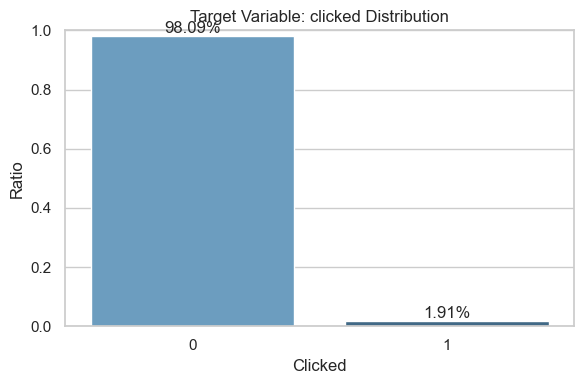

In [100]:
# Target Variable Analysis: 'clicked' (class imbalance check)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Compute clicked class distribution
clicked_counts = train["clicked"].value_counts()
clicked_ratio = train["clicked"].value_counts(normalize=True)

# Create summary DataFrame
df_clicked_summary = pd.DataFrame({
    "count": clicked_counts,
    "ratio": clicked_ratio
})

# Bar plot: clicked distribution
plt.figure(figsize=(6, 4))
sns.barplot(
    x=df_clicked_summary.index, 
    y=df_clicked_summary["ratio"], 
    hue=df_clicked_summary.index,       
    legend=False,                       
    palette="Blues_d"
)
plt.title("Target Variable: clicked Distribution")
plt.ylabel("Ratio")
plt.xlabel("Clicked")
plt.ylim(0, 1)

# Add ratio text on bars
for i, v in enumerate(df_clicked_summary["ratio"]):
    plt.text(i, v + 0.01, f"{v:.2%}", ha="center")

plt.tight_layout()
plt.savefig(SAVE_DIR / "target_clicked_distribution.png")
plt.show()

### Target Variable Analysis — `clicked`

- **Positive rate: 1.91%** → Severe class imbalance confirmed.
- Due to **extreme imbalance + 10M+ rows**, initial model training proceeded **without resampling** to avoid overfitting minority class.
- Class imbalance handled via `scale_pos_weight` in tree-based models.

In [101]:
# Train / Valid set split
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(
    train.index, 
    test_size=0.2, 
    stratify=train["clicked"], 
    random_state=42
)

train_df = train.loc[train_idx]
valid_df = train.loc[val_idx]

print(f"Train: {train_df.shape}, Valid: {valid_df.shape}")

Train: (8563343, 119), Valid: (2140836, 119)


In [102]:
# missing value summary
na_counts = train_df.isna().sum()
na_ratio = (train_df.isna().mean() * 100).round(2).astype(str) + '%'
na_df = pd.concat([na_counts, na_ratio], axis=1)
na_df.columns = ["missing_count", "missing_ratio"]
na_df = na_df[na_df["missing_count"] > 0]
na_df = na_df.sort_values(by="missing_count", ascending=False)

print(na_df.head(4))

           missing_count missing_ratio
feat_e_3          868734        10.14%
feat_a_8           14811         0.17%
feat_a_15          14811         0.17%
feat_a_17          14811         0.17%


### Missing Value Check

Most features show negligible missingness (below 0.2%), except `feat_e_3` with ~10% missing rate.  
→ Only `feat_e_3` may require special handling.

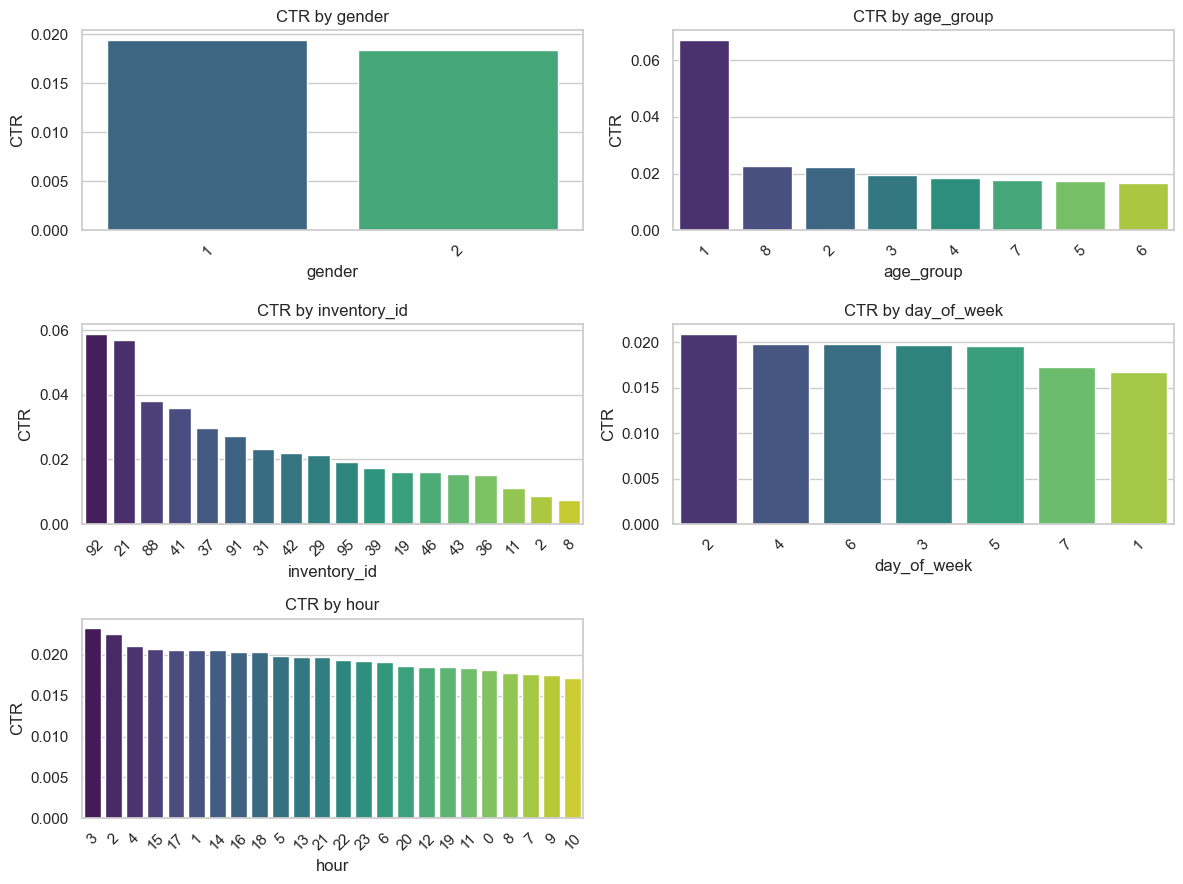

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = ["gender", "age_group", "inventory_id", "day_of_week", "hour"]

n = len(cat_cols)
ncols = 2
nrows = (n + 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))

for idx, col in enumerate(cat_cols):
    row, col_idx = divmod(idx, ncols)
    ax = axes[row][col_idx] if nrows > 1 else axes[col_idx]

    ctr = train_df.groupby(col)["clicked"].mean().sort_values(ascending=False)
    sns.barplot(x=ctr.index.astype(str), y=ctr.values, ax=ax, palette="viridis")
    ax.set_title(f"CTR by {col}")
    ax.set_ylabel("CTR")
    ax.set_xlabel(col)
    ax.tick_params(axis='x', rotation=45)

# Hide any empty subplot
for j in range(idx + 1, nrows * ncols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

### CTR by categorical features
- Noticeable CTR gaps in age_group and inventory_id → key segmentation signals
- Day of week and hour show mild but consistent trends
- No meaningful difference by gender

In [104]:
# Convert selected columns to category dtype
def convert_to_category(df, cols):
    out = df.copy()
    for c in cols:
        if c in out.columns:
            out[c] = out[c].astype("Float64").round().astype("Int64").astype("category")
    return out

# Categorical columns
cat_cols = ["gender", "age_group", "inventory_id", "day_of_week", "hour"]
l_feat_discrete = [
    'l_feat_1', 'l_feat_2', 'l_feat_3','l_feat_4', 'l_feat_8', 'l_feat_13',
    'l_feat_16', 'l_feat_18', 'l_feat_19', 'l_feat_20', 'l_feat_21',
    'l_feat_22', 'l_feat_23', 'l_feat_24', 'l_feat_26', 'l_feat_27'
]

# Apply conversion
train_df = convert_to_category(train_df, cat_cols + l_feat_discrete)
valid_df = convert_to_category(valid_df, cat_cols + l_feat_discrete)

In [105]:
# Identify l_feat_* variables treated as continuous
l_feat_continuous = [col for col in train_df.columns if col.startswith("l_feat_") and col not in l_feat_discrete]
print("Continuous l_feat_* features:", l_feat_continuous)

Continuous l_feat_* features: ['l_feat_5', 'l_feat_6', 'l_feat_7', 'l_feat_9', 'l_feat_10', 'l_feat_11', 'l_feat_12', 'l_feat_14', 'l_feat_15', 'l_feat_17', 'l_feat_25']


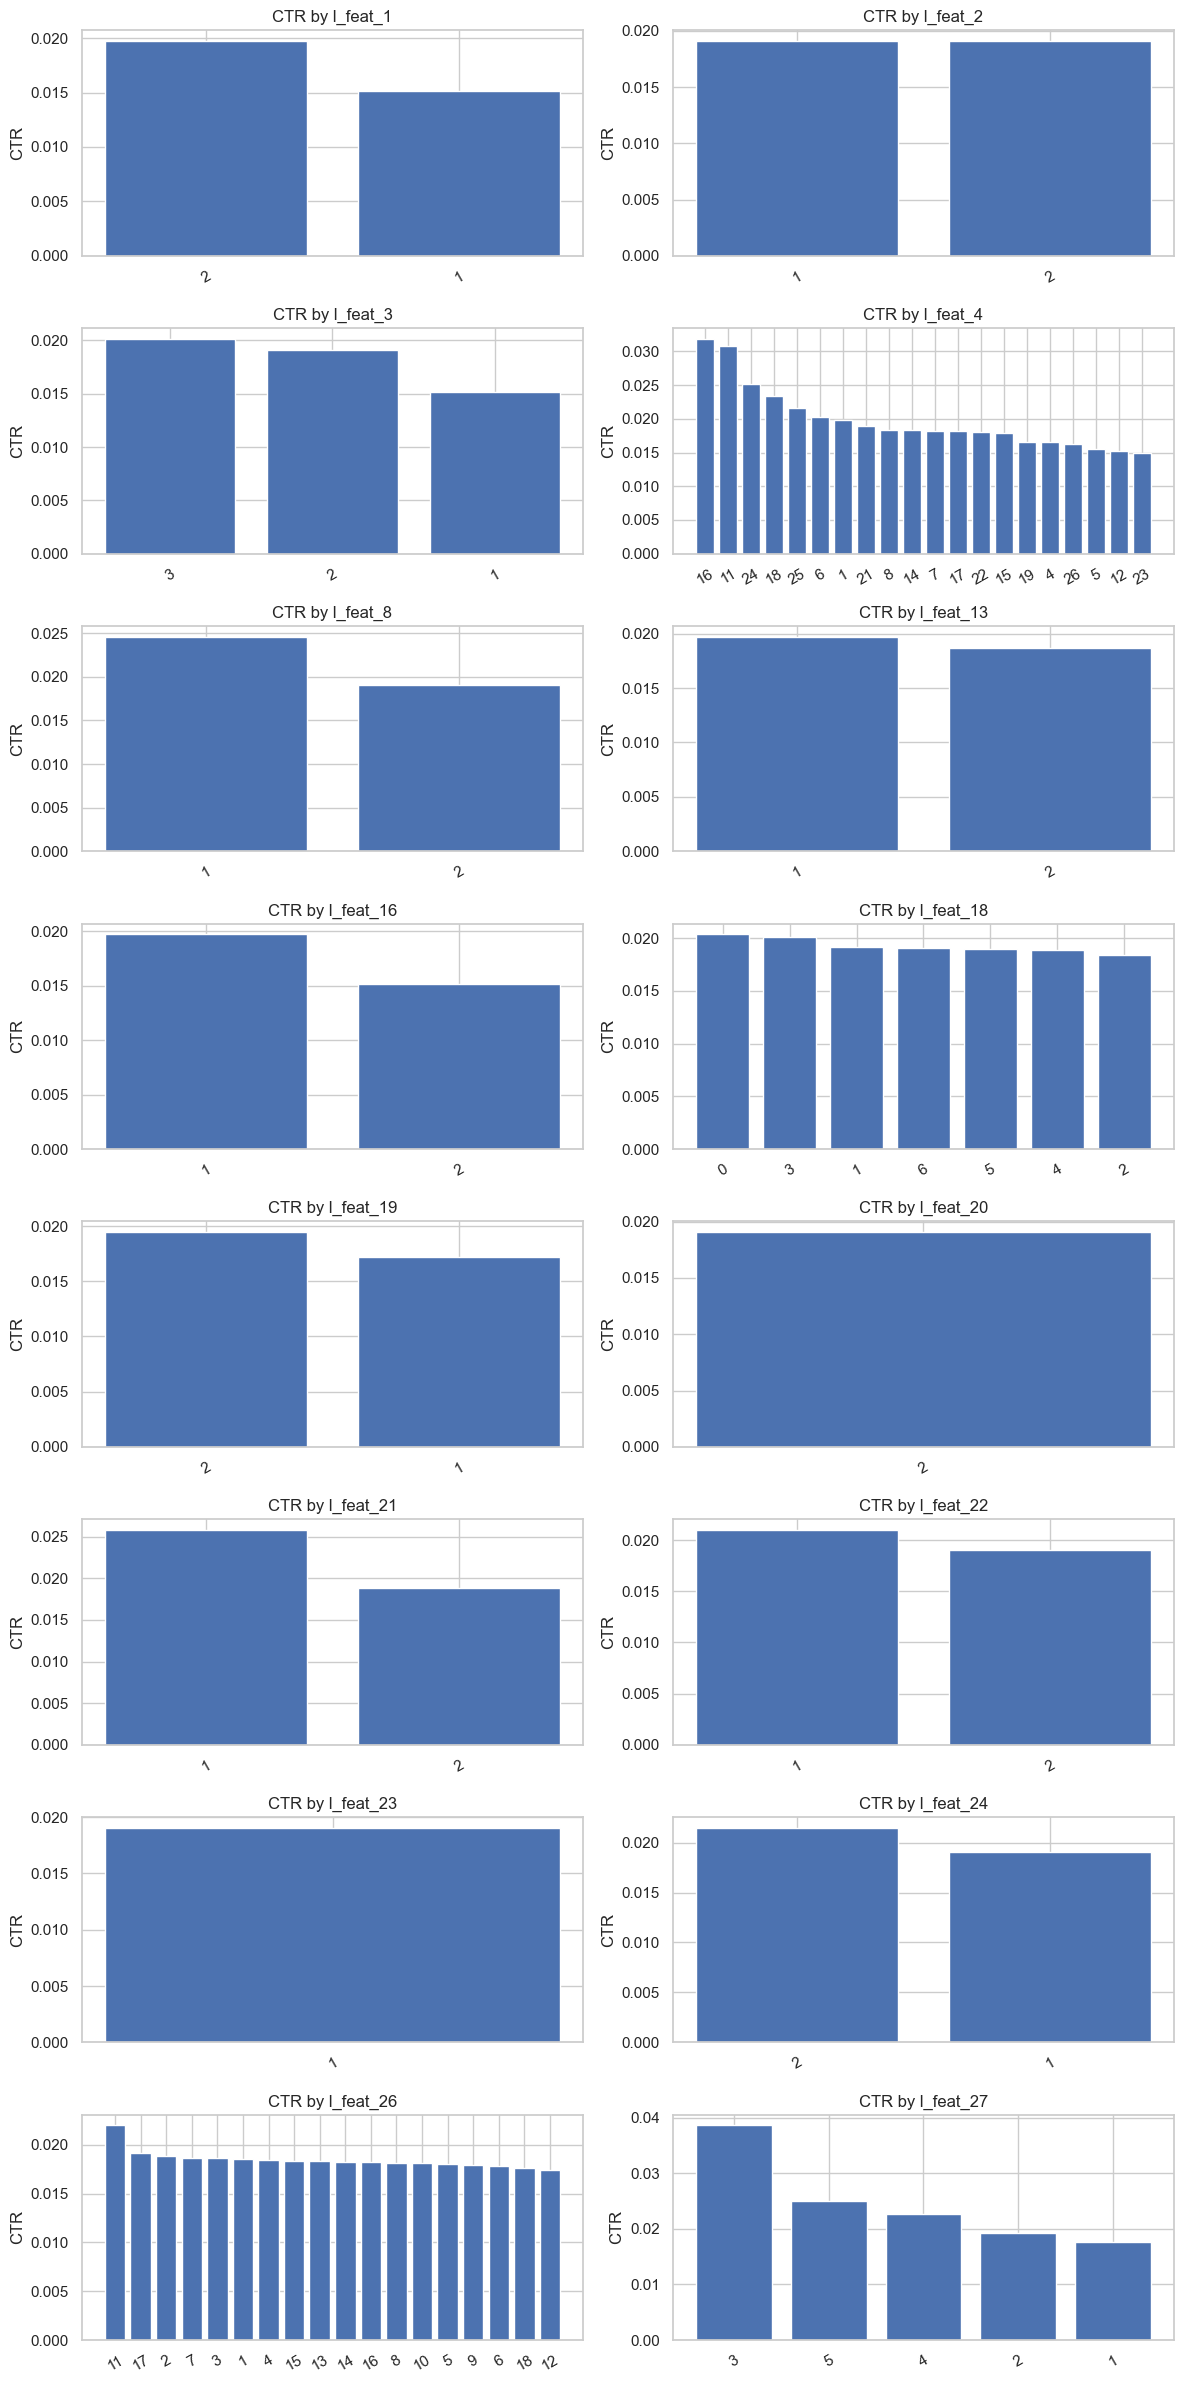

In [106]:
# CTR by discrete l_feat_* (Top-20 per variable, 2-column grid)
import matplotlib.pyplot as plt

TOP_K = 20
n_cols = 2
n_rows = (len(l_feat_discrete) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(l_feat_discrete):
    ctr = train_df.groupby(col)["clicked"].mean()
    ctr_maps[col] = ctr
    top_ctr = ctr.sort_values(ascending=False).head(TOP_K)

    axes[i].bar(top_ctr.index.astype(str), top_ctr.values)
    axes[i].set_title(f"CTR by {col}")
    axes[i].set_ylabel("CTR")
    axes[i].tick_params(axis="x", rotation=30)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [107]:
# Remove columns with minimal predictive value
# - l_feat_2, l_feat_13: Almost no CTR distribution difference between groups
# - l_feat_20, l_feat_23: Single unique value only (no variance)

columns_to_drop = ['l_feat_2', 'l_feat_13', 'l_feat_20', 'l_feat_23']

# Drop from train_df
train_df = train_df.drop(columns=columns_to_drop, errors='ignore')
print(f"Train shape after dropping: {train_df.shape}")


# Verify columns are removed
print(f"Dropped columns still in train: {[col for col in columns_to_drop if col in train_df.columns]}")
print(f"Dropped columns still in test: {[col for col in columns_to_drop if col in test_df.columns]}")

# Drop from test_df  
valid_df = valid_df.drop(columns=columns_to_drop, errors='ignore')
print(f"valid shape after dropping: {valid_df.shape}")
print(f"Dropped columns still in valid: {[col for col in columns_to_drop if col in test_df.columns]}")

Train shape after dropping: (8563343, 115)
Dropped columns still in train: []
Dropped columns still in test: ['l_feat_2', 'l_feat_13', 'l_feat_20', 'l_feat_23']
valid shape after dropping: (2140836, 115)
Dropped columns still in valid: ['l_feat_2', 'l_feat_13', 'l_feat_20', 'l_feat_23']


In [108]:
# l_feat_continuous - Missing value ratio
na_ratio_cont = train_df[l_feat_continuous].isnull().mean().sort_values(ascending=False)
print(na_ratio_cont)

# l_feat_continuous - Summary statistics
train_df[l_feat_continuous].describe().T

l_feat_5     0.0
l_feat_6     0.0
l_feat_7     0.0
l_feat_9     0.0
l_feat_10    0.0
l_feat_11    0.0
l_feat_12    0.0
l_feat_14    0.0
l_feat_15    0.0
l_feat_17    0.0
l_feat_25    0.0
dtype: float64


,count,mean,std,min,25%,50%,75%,max
l_feat_5,8563343.0,393.831573,289.999451,1.0,105.0,376.0,652.0,1079.0
l_feat_6,8563343.0,314.871948,231.341766,1.0,109.0,279.0,471.0,903.0
l_feat_7,8563343.0,147.892914,71.928543,1.0,94.0,146.0,212.0,313.0
l_feat_9,8563343.0,212.799393,125.099663,1.0,101.0,224.0,309.0,476.0
l_feat_10,8563343.0,123.927483,62.091522,1.0,83.0,125.0,179.0,262.0
l_feat_11,8563343.0,623.430664,392.182800,1.0,288.0,594.0,949.0,1527.0
l_feat_12,8563343.0,2348.103027,1541.098267,1.0,878.0,2247.0,3916.0,5061.0
l_feat_14,8563343.0,1906.478271,978.644592,1.0,1055.0,2114.0,2924.0,3245.0
l_feat_15,8563343.0,1298.203369,787.244324,1.0,613.0,1190.0,2303.0,2590.0
l_feat_17,8563343.0,212.799393,125.099663,1.0,101.0,224.0,309.0,476.0


In [109]:
# Drop highly correlated or near-constant columns

# l_feat_9 and l_feat_17: perfectly correlated --> drop one
corr_value = train_df[['l_feat_9', 'l_feat_17']].corr().iloc[0, 1]
print(f"Correlation between l_feat_9 and l_feat_17: {corr_value:.4f}")
train_df.drop(columns=['l_feat_17'], inplace=True)

# l_feat_25: CTR distribution nearly identical to another variable → low predictive value
train_df.drop(columns=['l_feat_25'], inplace=True)
valid_df.drop(columns=['l_feat_17', 'l_feat_25'], errors='ignore', inplace=True)


Correlation between l_feat_9 and l_feat_17: 1.0000


In [110]:
# Convert continuous l_feat_* columns to integer (based on observed value distribution)
int_cols = ['l_feat_5', 'l_feat_6', 'l_feat_7', 'l_feat_9', 'l_feat_10',
            'l_feat_11', 'l_feat_12', 'l_feat_14', 'l_feat_15']
train_df[int_cols] = train_df[int_cols].astype('int')
valid_df[int_cols] = valid_df[int_cols].astype('int')

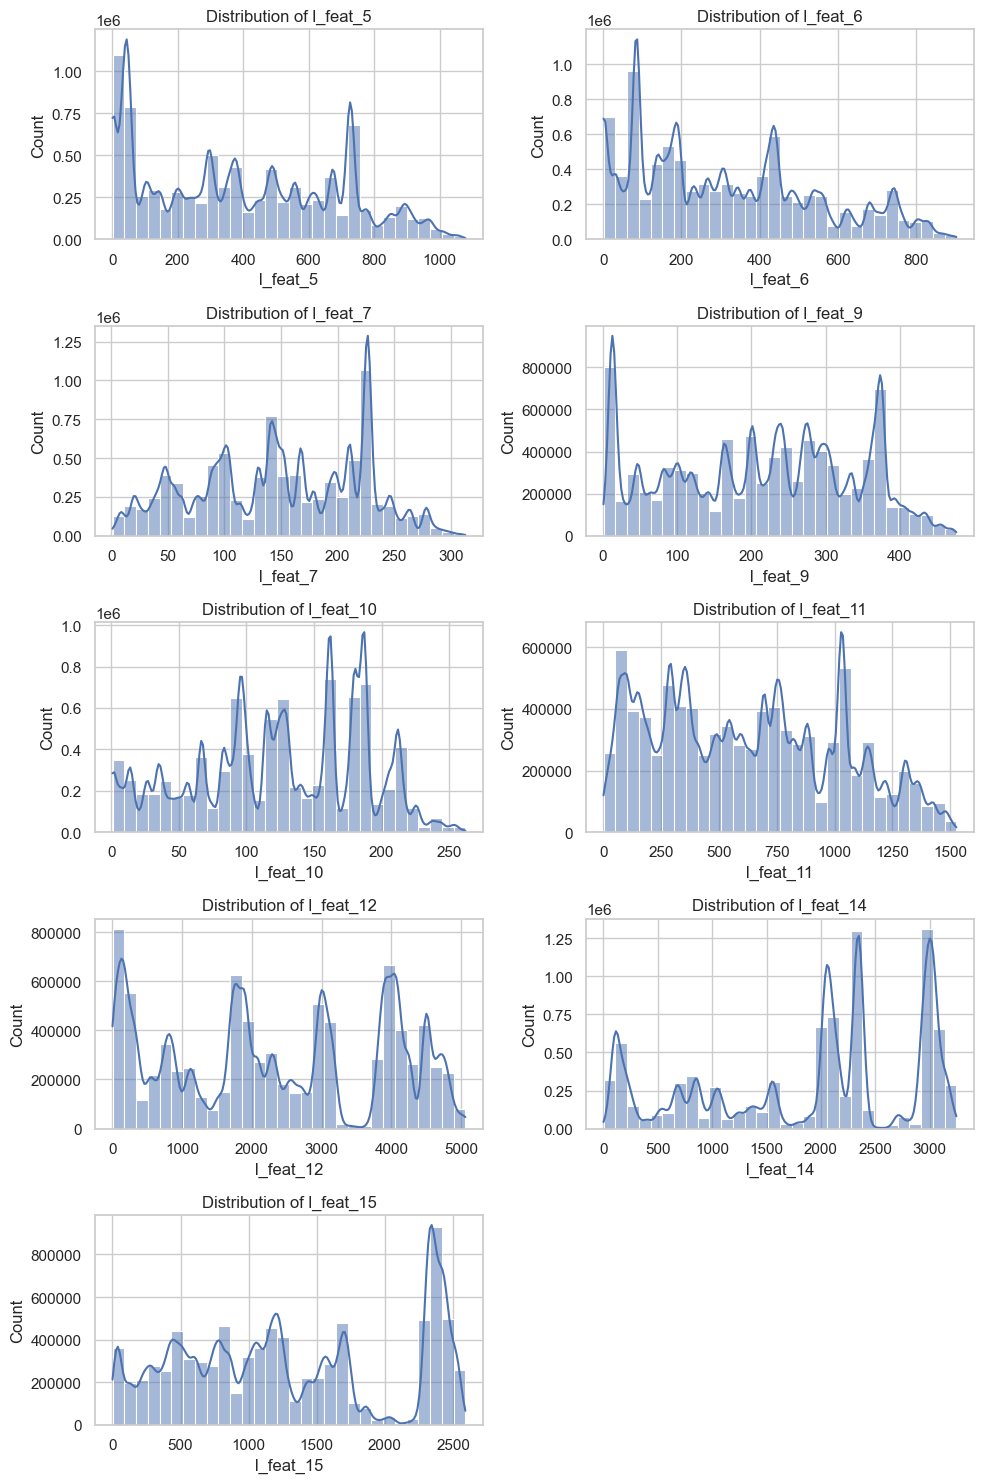

In [111]:
# Plot histograms for l_feat_* integer features (2 plots per row)
import matplotlib.pyplot as plt
import seaborn as sns

n_cols = 2
n_rows = (len(int_cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(int_cols):
    sns.histplot(data=train_df, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

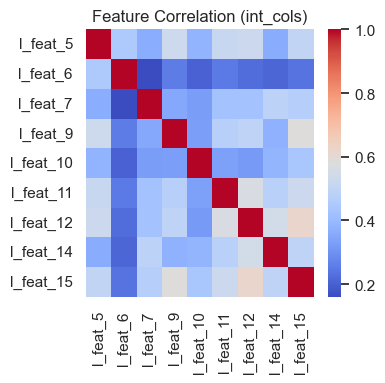

In [113]:
# X vs. X correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(4, 4))
sns.heatmap(train_df[int_cols].corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation (int_cols)")
plt.tight_layout()
plt.show()

# List highly correlated pairs
corr_matrix = train_df[int_cols].corr().abs()
np.fill_diagonal(corr_matrix.values, 0)

threshold = 0.8
high_corr_pairs = np.where(corr_matrix > threshold)
printed = set()

found = False
for i, j in zip(*high_corr_pairs):
    pair = tuple(sorted((corr_matrix.index[i], corr_matrix.columns[j])))
    if pair not in printed:
        printed.add(pair)
        if not found:
            print(f"Features with correlation > {threshold}:\n")
            found = True
        print(f"{pair[0]} ↔ {pair[1]}: {corr_matrix.iloc[i, j]:.3f}")

### l_feat_* — what I kept, dropped, and why

- **Type decision.** Treat as *categorical* when #unique ≤ **25**, otherwise keep as integer. This is a pragmatic cut-off to avoid high‑cardinality sparsity; scikit‑learn notes that OHE with many categories inflates dimensionality and suggests alternatives (e.g., target/ordinal encoders). XGBoost can use pandas `category` directly via `enable_categorical`, so OHE was not required.  [oai_citation:0‡scikit-learn.org](https://scikit-learn.org/stable/modules/preprocessing.html) [oai_citation:1‡xgboost.readthedocs.io](https://xgboost.readthedocs.io/en/release_1.7.0/python/python_api.htm)

- **Constant / near-constant / duplicate signals → drop.**  
  Dropped single‑level features (`l_feat_20`, `l_feat_23`) and a duplicate signal (`l_feat_17` ≈ `l_feat_9`). Removing (near-)constant features is standard (VarianceThreshold). 

- **Low utility by outcome separation.**  
  `l_feat_2`, `l_feat_13` showed almost identical CTR by bins to peer feature → removed (no predictive separation). *(dataset-specific decision)*

- **Distributions.**  
  Continuous `l_feat_*` are multi‑modal; kept as **int** after inspecting value quantization (summary & histograms).


In [114]:
# feat_e_* features — summary, histograms, correlations
# 1. feat_e_* feature summary
feat_e_cols = sorted([c for c in train_df.columns if c.startswith('feat_e_')])
train_df[feat_e_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
feat_e_1,8549647.0,61.125225,9.929082,0.361111,63.555557,65.000000,65.000000,65.000000
feat_e_10,8549647.0,-303.853973,209.873932,-2391.942871,-434.457153,-268.785706,-133.414291,0.014286
feat_e_2,8549647.0,-2570.793701,2290.272217,-311604.250000,-3852.426025,-2287.833252,-851.666687,18073.945312
feat_e_3,7694609.0,9.880831,11.143710,1.136364,3.409091,5.454545,10.227273,170.454544
feat_e_4,8549647.0,-0.049464,0.005345,-0.100000,-0.050000,-0.050000,-0.050000,0.000000
feat_e_5,8549647.0,-0.055604,0.110109,-2.431373,-0.098039,-0.019608,0.019608,0.019608
feat_e_6,8549647.0,-0.064738,0.075751,-1.701299,-0.090909,-0.038961,-0.012987,0.012987
feat_e_7,8549647.0,46.402946,70.329140,-0.062500,3.250000,21.375000,59.312500,1277.375000
feat_e_8,8549647.0,-186.463333,120.833900,-783.755554,-263.622223,-172.155548,-89.577774,0.022222
feat_e_9,8549647.0,-18.979820,26.880898,-587.677429,-25.043011,-10.193548,-2.344086,0.010753


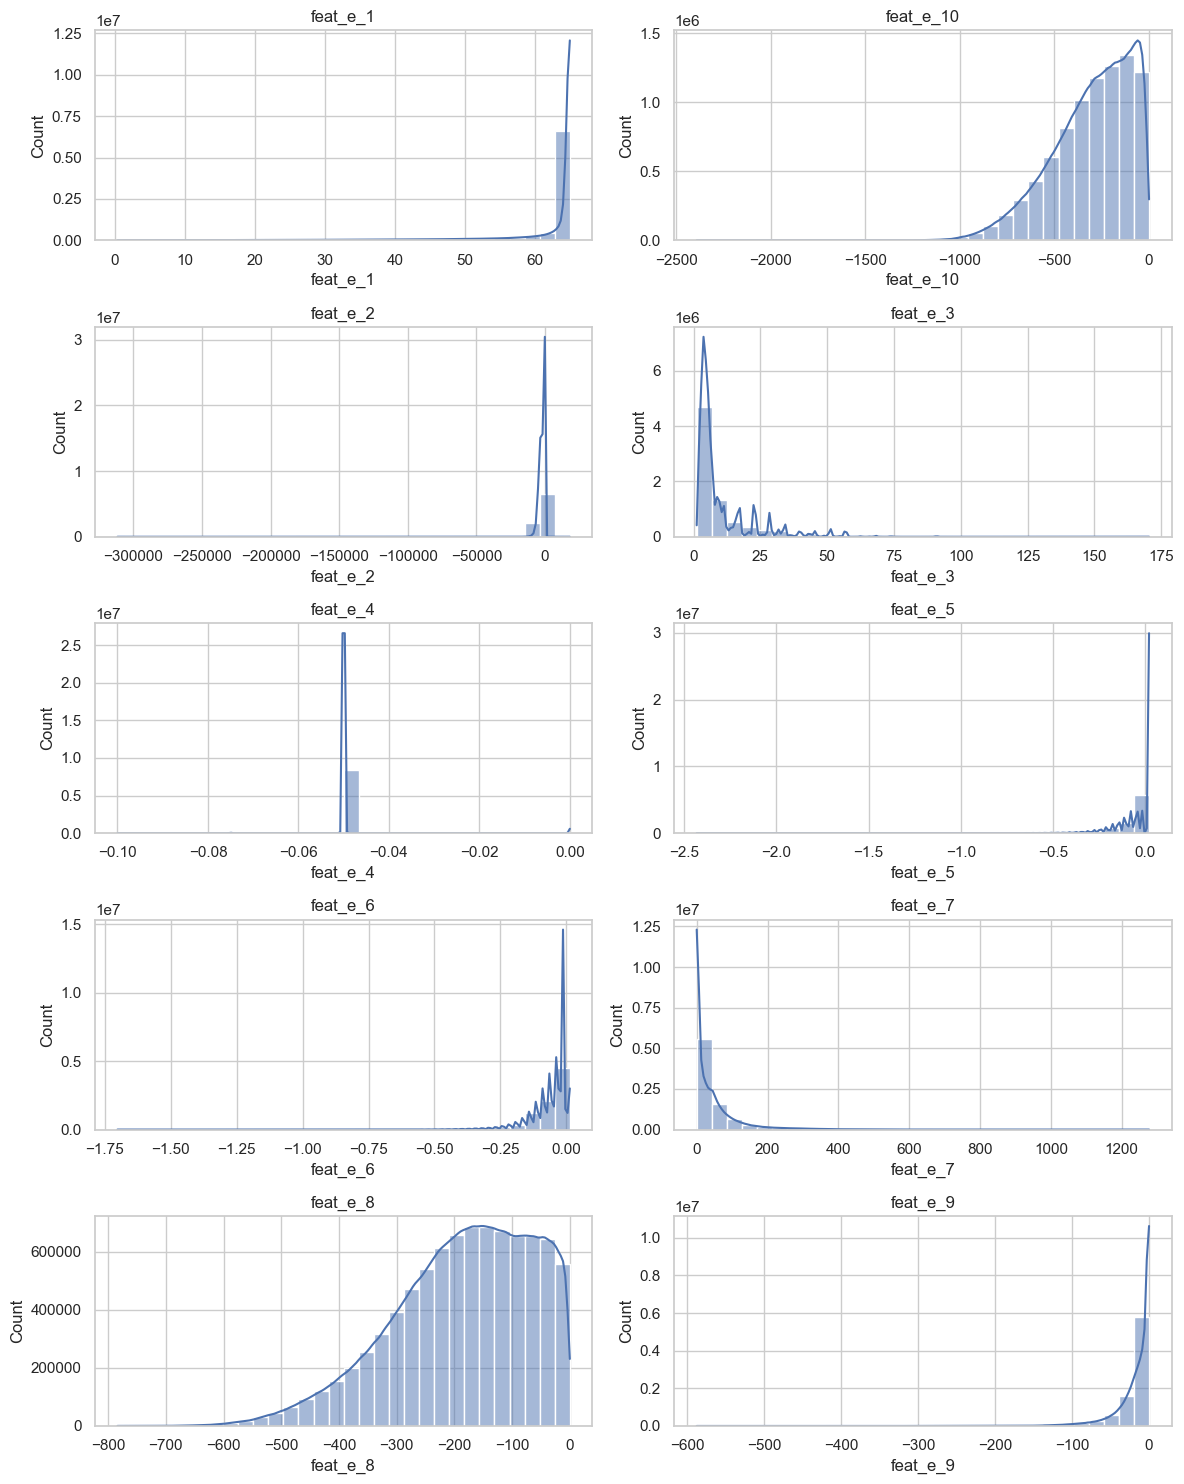

In [116]:
# 2. Histogram plots (2 per row)
import matplotlib.pyplot as plt
import seaborn as sns
import math

cols = feat_e_cols
n_cols = 2
n_rows = math.ceil(len(cols) / n_cols)
plt.figure(figsize=(12, 3 * n_rows))

for idx, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(train_df[col], bins=30, kde=True)
    plt.title(f"{col}")
    plt.tight_layout()

plt.show()

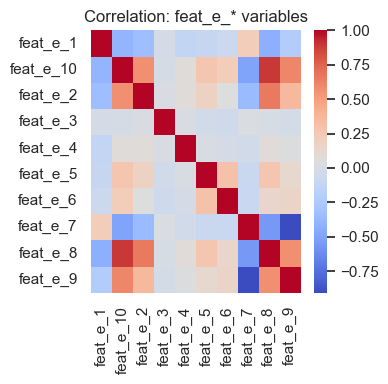

Highly correlated feat_e_* pairs (r > 0.8):
feat_e_10 ↔ feat_e_8: 0.890
feat_e_7 ↔ feat_e_9: 0.908


In [145]:
# 3. Correlation matrix and highly correlated pairs
import numpy as np

plt.figure(figsize=(4,4))
sns.heatmap(train_df[feat_e_cols].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation: feat_e_* variables")
plt.tight_layout()
plt.show()

# Print only if strong correlation exists
corr_matrix = train_df[feat_e_cols].corr().abs()
np.fill_diagonal(corr_matrix.values, 0)

threshold = 0.8
high_corr = np.where(corr_matrix > threshold)
printed = set()

results = []
for i, j in zip(*high_corr):
    pair = tuple(sorted((corr_matrix.index[i], corr_matrix.columns[j])))
    if pair not in printed:
        printed.add(pair)
        results.append((pair[0], pair[1], corr_matrix.iloc[i, j]))

if results:
    print("Highly correlated feat_e_* pairs (r > 0.8):")
    for a, b, r in results:
        print(f"{a} ↔ {b}: {r:.3f}")

### feat_e_* — summary & insights

- **Skewed but not transformed.** Most features are heavily skewed or long-tailed, but no transformation (e.g., log) was applied. Tree-based models such as XGBoost and LightGBM are robust to feature skewness, as they rely on value splits, not distributional assumptions.  
  [scikit-learn docs](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms),  
  [XGBoost docs](https://xgboost.readthedocs.io/en/stable/)

- **Correlated pairs identified.** `feat_e_10` and `feat_e_8` (r = 0.89), `feat_e_7` and `feat_e_9` (r = 0.91) showed high linear correlation. No action taken for now, but one of each pair may be dropped if collinearity impacts performance.

- **Distributions are diverse.** Some variables are dense around 0 (e.g., `feat_e_6`), while others have wide value ranges and long tails (e.g., `feat_e_2`). No strong redundancy observed except in correlated pairs.

In [121]:
 # feat_d_* features — summary, histograms, correlations
 # Identify feat_d_* columns
feat_d_cols = sorted([c for c in train_df.columns if c.startswith("feat_d_")])

# 1. Summary statistics
train_df[feat_d_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
feat_d_1,8549647.0,0.362487,0.067685,0.000000,0.376623,0.389610,0.389610,0.389610
feat_d_2,8549647.0,1.616537,0.651351,0.000000,1.600000,1.933333,2.000000,2.000000
feat_d_3,8549647.0,1.475151,0.563570,0.000000,1.588235,1.764706,1.764706,1.764706
feat_d_4,8549647.0,9.274422,9.778038,0.000000,2.108108,6.000000,13.785633,78.000000
feat_d_5,8549647.0,-0.218758,0.116756,-0.303030,-0.303030,-0.292929,-0.111111,0.000000
feat_d_6,8549647.0,-0.297417,0.168547,-0.422535,-0.422535,-0.408451,-0.140845,0.000000


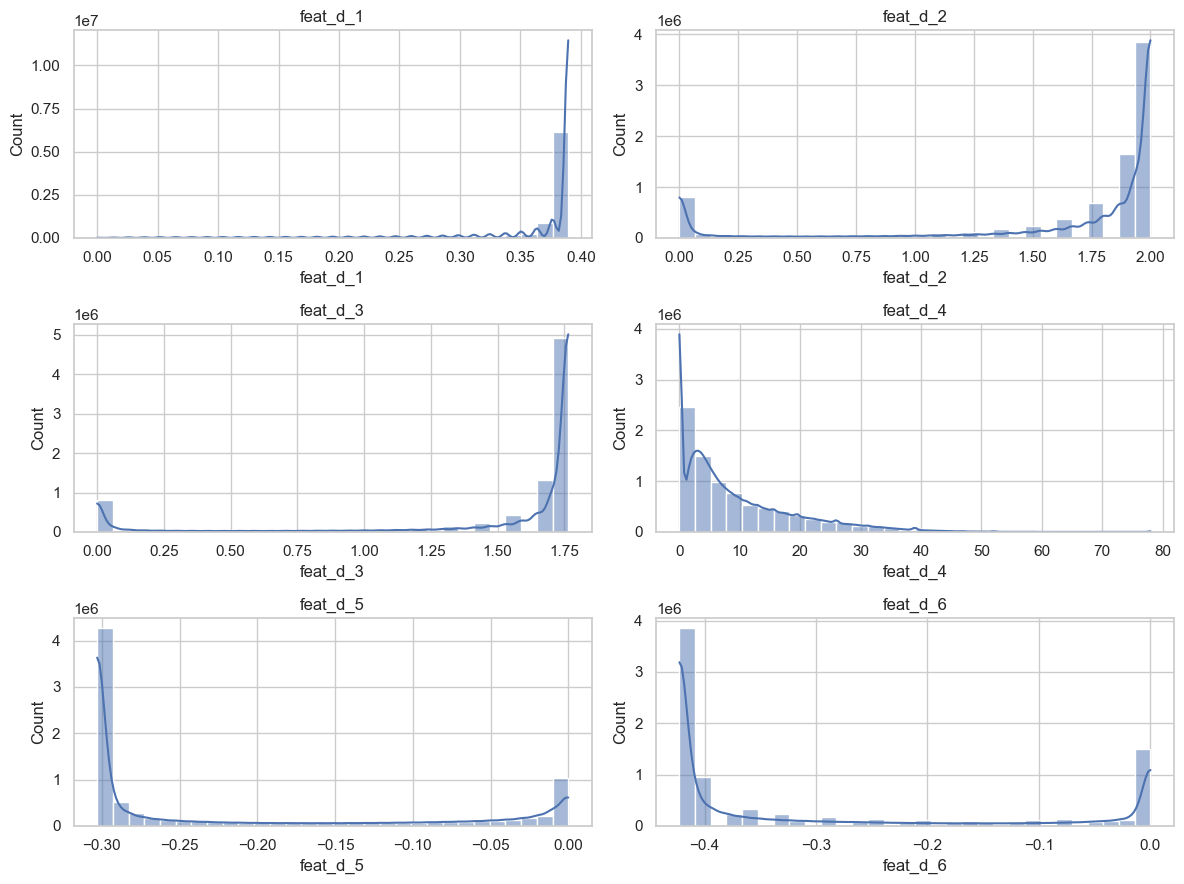

In [123]:
# 2. Histogram plots (2 per row)
import matplotlib.pyplot as plt
import seaborn as sns
import math

cols = feat_d_cols
n_cols = 2
n_rows = math.ceil(len(cols) / n_cols)
plt.figure(figsize=(12, 3 * n_rows))

for idx, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(train_df[col], bins=30, kde=True)
    plt.title(col)
    plt.tight_layout()

plt.show()

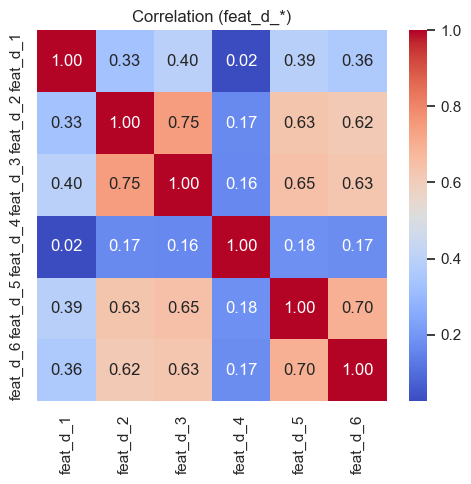

In [142]:
# 3. Correlation matrix and high-corr pairs
import numpy as np

corr_matrix = train_df[feat_d_cols].corr().abs()
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation (feat_d_*)")
plt.tight_layout()
plt.show()

# Print only if high correlation exists
np.fill_diagonal(corr_matrix.values, 0)
threshold = 0.8
high_corr = np.where(corr_matrix > threshold)
printed = set()
results = []

for i, j in zip(*high_corr):
    pair = tuple(sorted((corr_matrix.index[i], corr_matrix.columns[j])))
    if pair not in printed:
        printed.add(pair)
        results.append((pair[0], pair[1], corr_matrix.iloc[i, j]))

if results:
    print("Highly correlated feat_d_* pairs (r > 0.8):")
    for a, b, r in results:
        print(f"{a} ↔ {b}: {r:.3f}")

### feat_d_* — summary, distribution, correlation

- All variables are **continuous**, with noticeable **skewness** in distribution 
- No transformation applied at this stage, as **tree-based models (e.g., XGBoost)** are robust to skewed features.  

In [126]:
# feat_c_* features — summary, missing ratio, histograms, correlations
feat_c_cols = sorted([c for c in train_df.columns if c.startswith("feat_c_")])

# 1. Summary statistics
train_df[feat_c_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
feat_c_1,8549647.0,53.781235,12.940802,0.0,56.784985,58.635109,58.778076,58.849396
feat_c_2,8549647.0,9.177243,14.671859,0.0,0.081588,0.480112,10.546433,35.999992
feat_c_3,8549647.0,52.869156,24.399979,0.0,31.975409,59.106060,75.238960,83.000000
feat_c_4,8549647.0,25.627361,6.007428,0.0,26.119205,28.134329,28.625807,29.000000
feat_c_5,8549647.0,35.209797,12.758033,0.0,28.447369,41.173553,44.647549,47.000000
feat_c_6,8549647.0,6.394335,2.174810,0.0,5.957447,7.437186,7.801460,8.000000
feat_c_7,8549647.0,68.593964,16.507799,0.0,73.776207,73.954559,73.959229,74.000000
feat_c_8,8549647.0,23.155140,8.413702,0.0,17.422222,26.412699,30.181053,32.000000


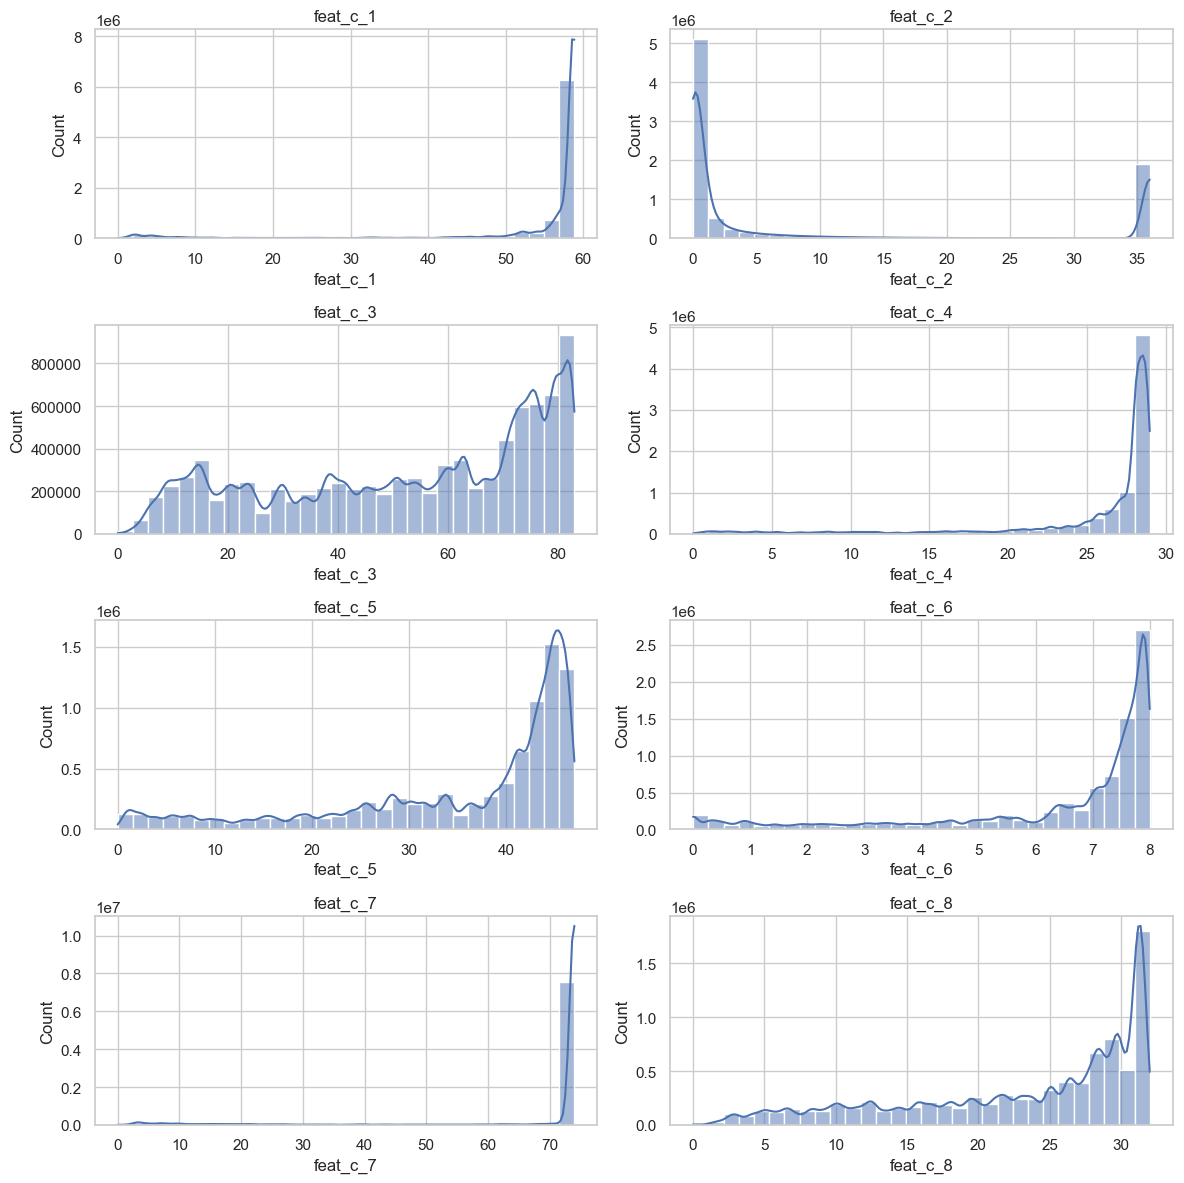

In [128]:
# 2. Histogram (2 plots per row)
import matplotlib.pyplot as plt
import seaborn as sns
import math

cols = feat_c_cols
n_cols = 2
n_rows = math.ceil(len(cols) / n_cols)
plt.figure(figsize=(12, 3 * n_rows))

for idx, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(train_df[col], bins=30, kde=True)
    plt.title(col)
    plt.tight_layout()

plt.show()

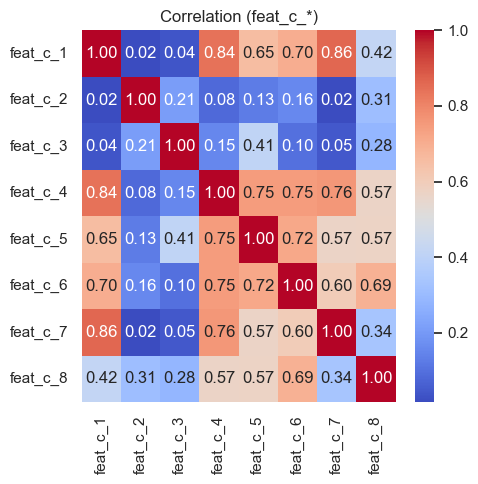

Highly correlated feat_c_* pairs (r > 0.8):
feat_c_1 ↔ feat_c_4: 0.840
feat_c_1 ↔ feat_c_7: 0.865


In [141]:
# 3. Correlation matrix and high-corr pairs
import numpy as np

corr_matrix = train_df[feat_c_cols].corr().abs()
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation (feat_c_*)")
plt.tight_layout()
plt.show()

np.fill_diagonal(corr_matrix.values, 0)
threshold = 0.8
high_corr = np.where(corr_matrix > threshold)
printed = set()
results = []

for i, j in zip(*high_corr):
    pair = tuple(sorted((corr_matrix.index[i], corr_matrix.columns[j])))
    if pair not in printed:
        printed.add(pair)
        results.append((pair[0], pair[1], corr_matrix.iloc[i, j]))

if results:
    print("Highly correlated feat_c_* pairs (r > 0.8):")
    for a, b, r in results:
        print(f"{a} ↔ {b}: {r:.3f}")

### feat_c_* — distribution and correlation insights

- Most variables are highly skewed with clear upper-end mode concentration.
- No transformation was applied, as tree-based models (e.g., XGBoost) are robust to monotonic transformations and skewed inputs.
- High correlation observed among:
  - `feat_c_1` ↔ `feat_c_4` (r = 0.84)
  - `feat_c_1` ↔ `feat_c_7` (r = 0.87)  
  These may be redundant; one can be removed if feature importance or SHAP values suggest overlap.

In [130]:
# feat_b_* features — summary, histograms, correlations

feat_b_cols = sorted([c for c in train_df.columns if c.startswith("feat_b_")])

# 1. Summary statistics
train_df[feat_b_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
feat_b_1,8549647.0,4.600941,26.507782,0.000000,3.752577,4.340206,4.618556,2066.103027
feat_b_2,8549647.0,-2.914865,2.866530,-278.433746,-4.337349,-3.373494,-0.216867,0.000000
feat_b_3,8549647.0,24.008724,25.338665,0.000000,6.037037,17.833334,35.537037,1172.740723
feat_b_4,8549647.0,0.770251,0.294549,0.000000,0.804124,0.907216,0.927835,1.319588
feat_b_5,8549647.0,-45.834209,35.168213,-979.368408,-70.631577,-41.561405,-15.631579,0.000000
feat_b_6,8549647.0,1373.559570,1457.979126,0.000000,419.833344,1170.916626,2069.583252,86991.835938


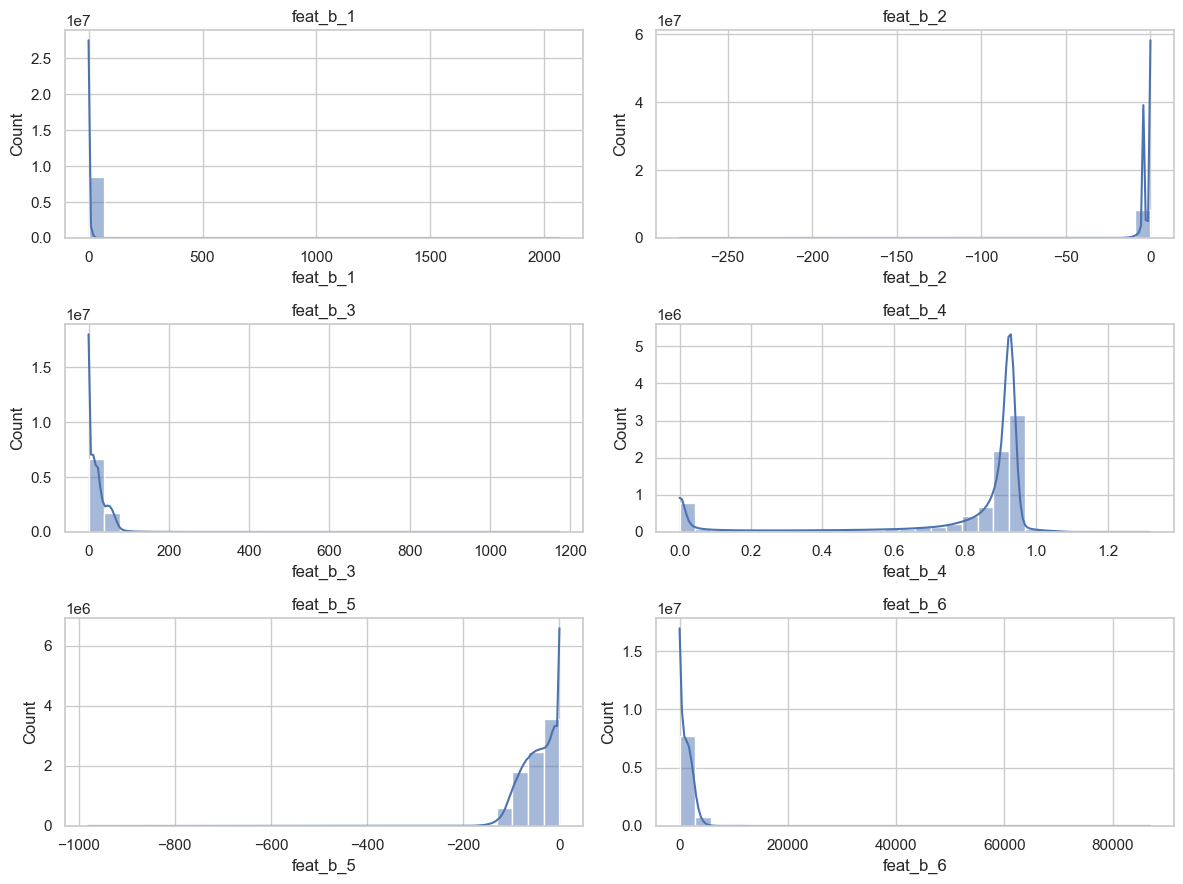

In [132]:
# 2. Histograms (2 per row)
import matplotlib.pyplot as plt
import seaborn as sns
import math

cols = feat_b_cols
n_cols = 2
n_rows = math.ceil(len(cols) / n_cols)
plt.figure(figsize=(12, 3 * n_rows))

for idx, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(train_df[col], bins=30, kde=True)
    plt.title(col)
    plt.tight_layout()

plt.show()

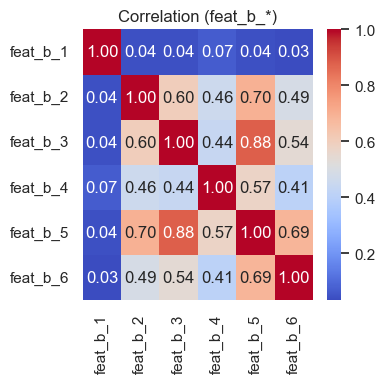

Highly correlated feat_b_* pairs (r > 0.8):
feat_b_3 ↔ feat_b_5: 0.880


In [139]:
# 3. Correlation analysis and high-corr pairs
import numpy as np

corr_b = train_df[feat_b_cols].corr().abs()
plt.figure(figsize=(4, 4))
sns.heatmap(corr_b, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation (feat_b_*)")
plt.tight_layout()
plt.show()

np.fill_diagonal(corr_b.values, 0)
threshold = 0.8
high = np.where(corr_b > threshold)
printed = set()
results = []

for i, j in zip(*high):
    pair = tuple(sorted((corr_b.index[i], corr_b.columns[j])))
    if pair not in printed:
        printed.add(pair)
        results.append((pair[0], pair[1], corr_b.iloc[i, j]))

if results:
    print("Highly correlated feat_b_* pairs (r > 0.8):")
    for a, b, r in results:
        print(f"{a} ↔ {b}: {r:.3f}")

### feat_b_* — distribution & correlation insights

- Most variables show **highly skewed distributions**, but no transformation applied as tree-based models are robust to such skewness.
- `feat_b_3` and `feat_b_5` are **highly correlated (r = 0.88)**. One of them may be dropped if multicollinearity affects performance later.

In [134]:
# feat_a_* features — summary, histograms, correlations

feat_a_cols = sorted([c for c in train_df.columns if c.startswith("feat_a_")])
# 1. Summary statistics
train_df[feat_a_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
feat_a_1,8548532.0,1.678859,4.539003,0.0,0.0000,0.0000,0.000000,14.400000
feat_a_10,8548532.0,3.632200,16.044237,0.0,0.0000,0.0000,0.000000,76.500000
feat_a_11,8548532.0,1.229118,6.193856,0.0,0.0000,0.0000,0.000000,37.799999
feat_a_12,8548532.0,0.545604,2.238973,0.0,0.0000,0.0000,0.000000,14.000000
feat_a_13,8548532.0,1.387227,5.294884,0.0,0.0000,0.0000,0.000000,47.700001
feat_a_14,8548532.0,3.255992,2.066549,0.0,1.6674,2.9029,3.834600,7.000000
feat_a_15,8548532.0,5.034220,14.618300,0.0,0.0000,0.0000,0.000000,62.099998
feat_a_16,8548532.0,0.670691,3.098954,0.0,0.0000,0.0000,0.000000,18.900000
feat_a_17,8548532.0,0.208677,0.590646,0.0,0.0000,0.0000,0.000000,3.600000
feat_a_18,8548532.0,4.395155,13.307856,0.0,0.0000,0.0000,0.000000,47.700001


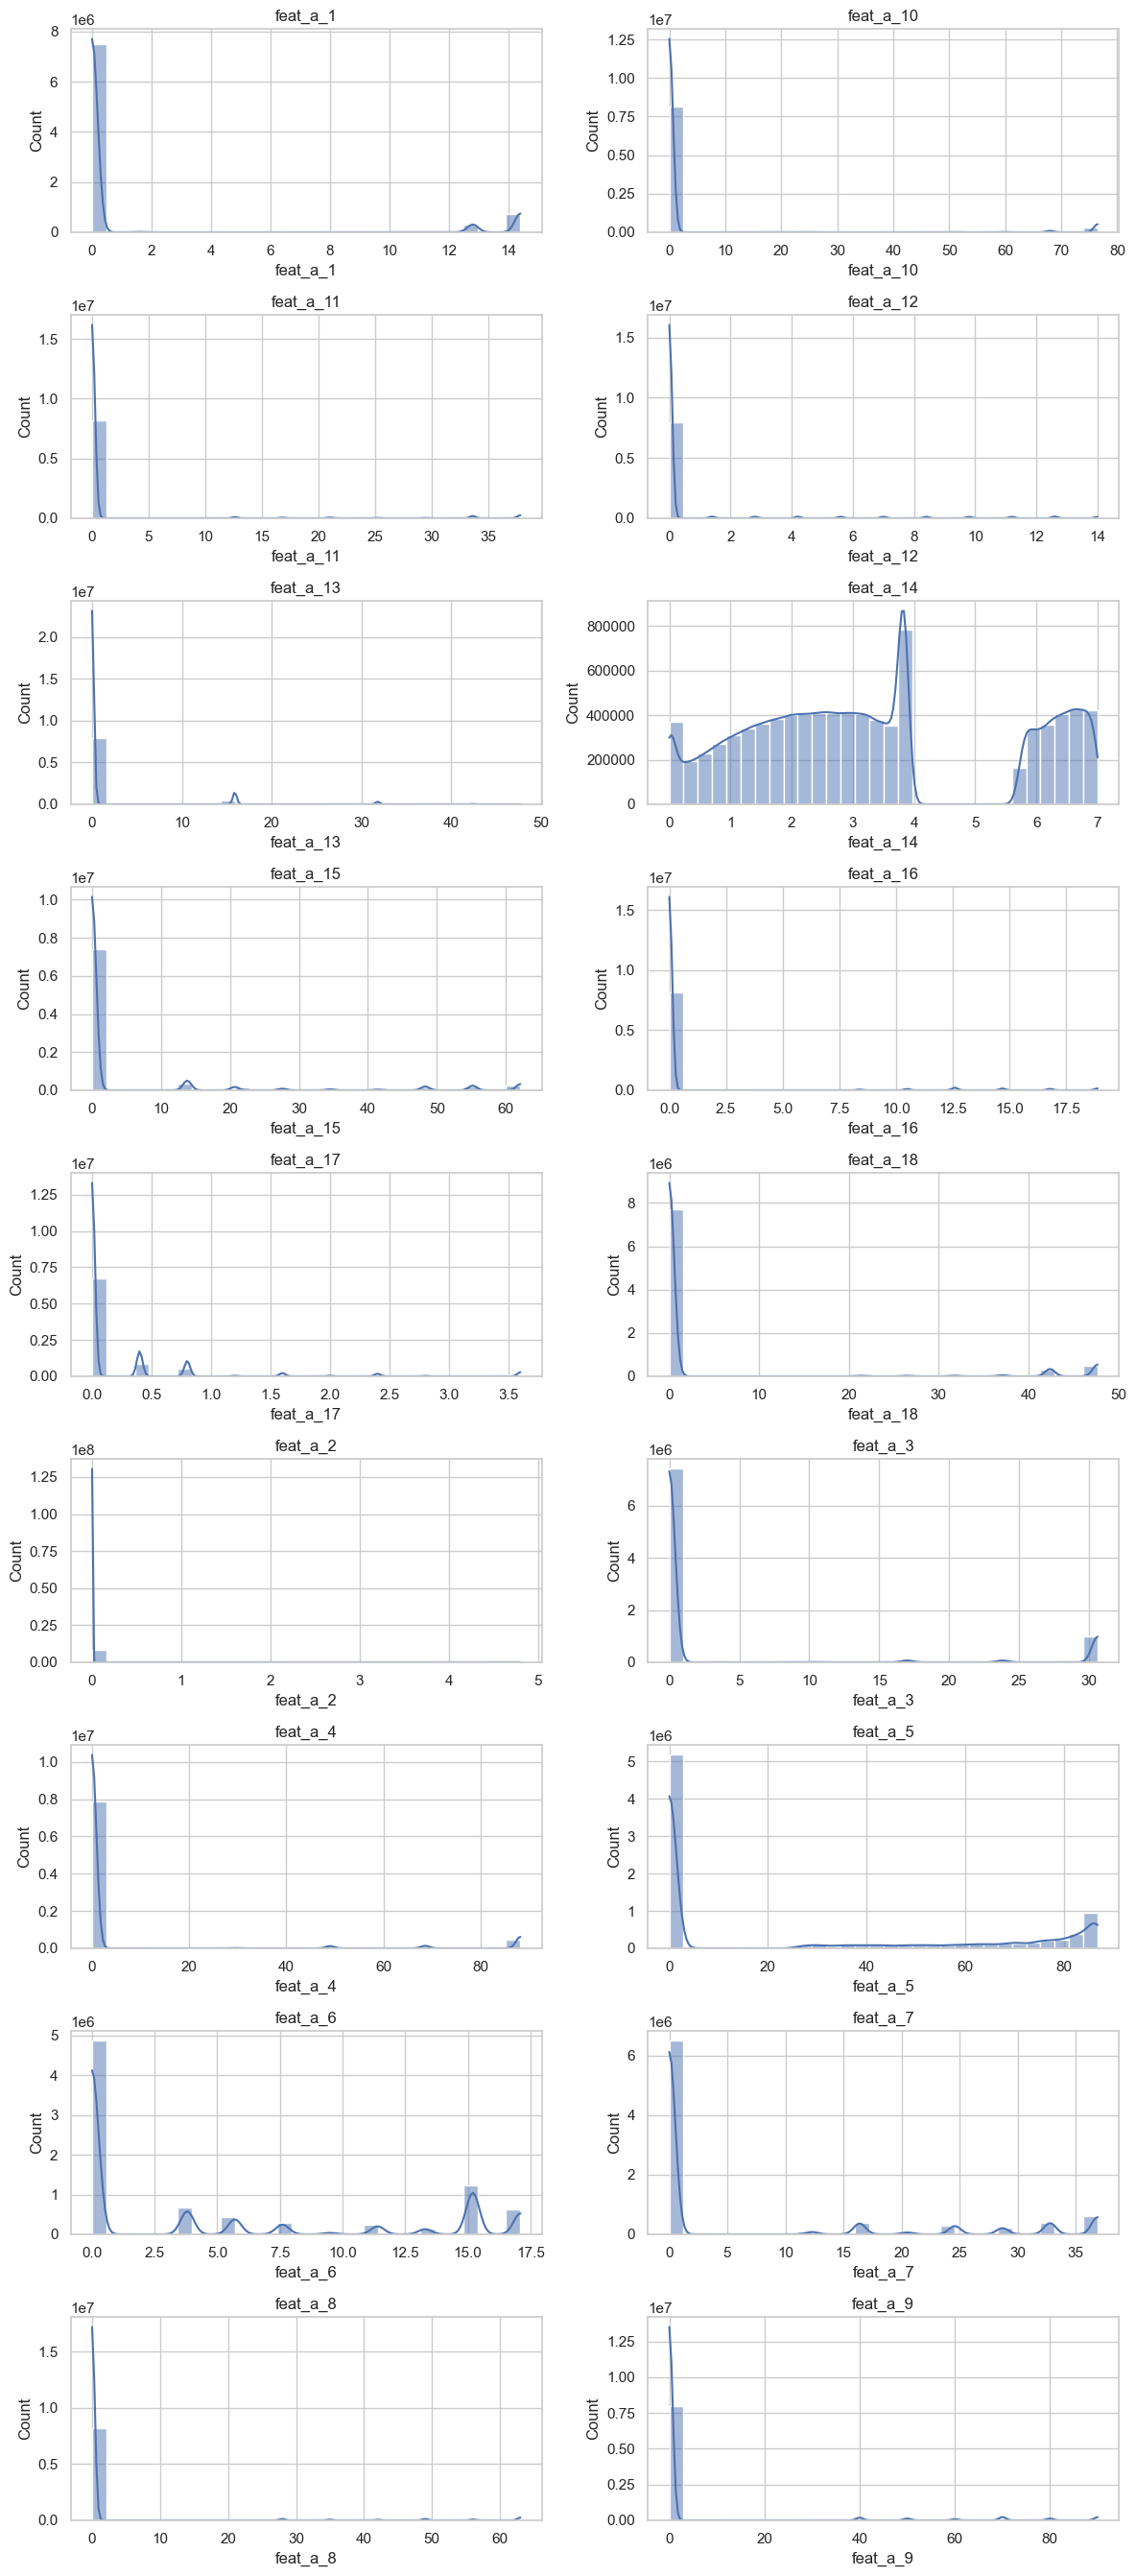

In [136]:
# 2. Histograms (2 per row)
import matplotlib.pyplot as plt
import seaborn as sns
import math

cols = feat_a_cols
n_cols = 2
n_rows = math.ceil(len(cols) / n_cols)
plt.figure(figsize=(12, 3 * n_rows))

for idx, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(train_df[col], bins=30, kde=True)
    plt.title(col)
    plt.tight_layout()

plt.show()

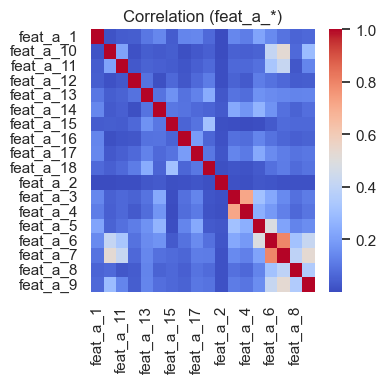

In [146]:
# 3. Correlation analysis and high-corr pairs
import numpy as np

corr_a = train_df[feat_a_cols].corr().abs()
plt.figure(figsize=(4,4))
sns.heatmap(corr_a, annot=False, cmap="coolwarm")
plt.title("Correlation (feat_a_*)")
plt.tight_layout()
plt.show()

np.fill_diagonal(corr_a.values, 0)
threshold = 0.8
high = np.where(corr_a > threshold)
printed = set()
results = []

for i, j in zip(*high):
    pair = tuple(sorted((corr_a.index[i], corr_a.columns[j])))
    if pair not in printed:
        printed.add(pair)
        results.append((pair[0], pair[1], corr_a.iloc[i, j]))

if results:
    print("Highly correlated feat_a_* pairs (r > 0.8):")
    for a, b, r in results:
        print(f"{a} ↔ {b}: {r:.3f}")

### feat_a_* — distribution insights

- **Zero-heavy features.**  
  Most `feat_a_*` (e.g., `a_1`~`a_13`, `a_15`~`a_18`) are zero-inflated, indicating potentially sparse usage or missing-like patterns. No transformation applied due to tree-based model robustness.

- **Suspicious empty region.**  
  `feat_a_14` shows a clear gap between ~4.0–5.6; this may suggest censored or structurally missing values. Will investigate if it corresponds to a masked value or encoding error.

- **Distributions.**  
  All features are highly skewed. Consistent with tree-based handling, no normalization or transformation applied.

In [147]:
# history_a_* features — summary, histograms, correlations
history_a_cols = [c for c in train.columns if c.startswith("history_a_")]
# 1. Summary statistics
train_df[history_a_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
history_a_1,8549647.0,0.113681,0.384140,0.000000,0.028232,0.049893,0.092868,18.709814
history_a_2,8549647.0,-0.110249,0.274867,-58.611111,-0.111111,-0.055556,0.000000,0.000000
history_a_3,8549647.0,0.049476,0.111468,0.000000,0.012195,0.024390,0.060976,20.975609
history_a_4,8549647.0,-348.968536,300.909851,-7754.714355,-497.714294,-279.857147,-123.857140,0.000000
history_a_5,8549647.0,-0.014994,0.038825,-7.913043,-0.014493,0.000000,0.000000,0.000000
history_a_6,8549647.0,-172.514771,148.074905,-3826.857178,-245.285721,-139.285721,-62.000000,0.000000
history_a_7,8549647.0,-12.087947,10.406300,-235.596161,-17.230770,-9.750000,-4.288462,0.000000


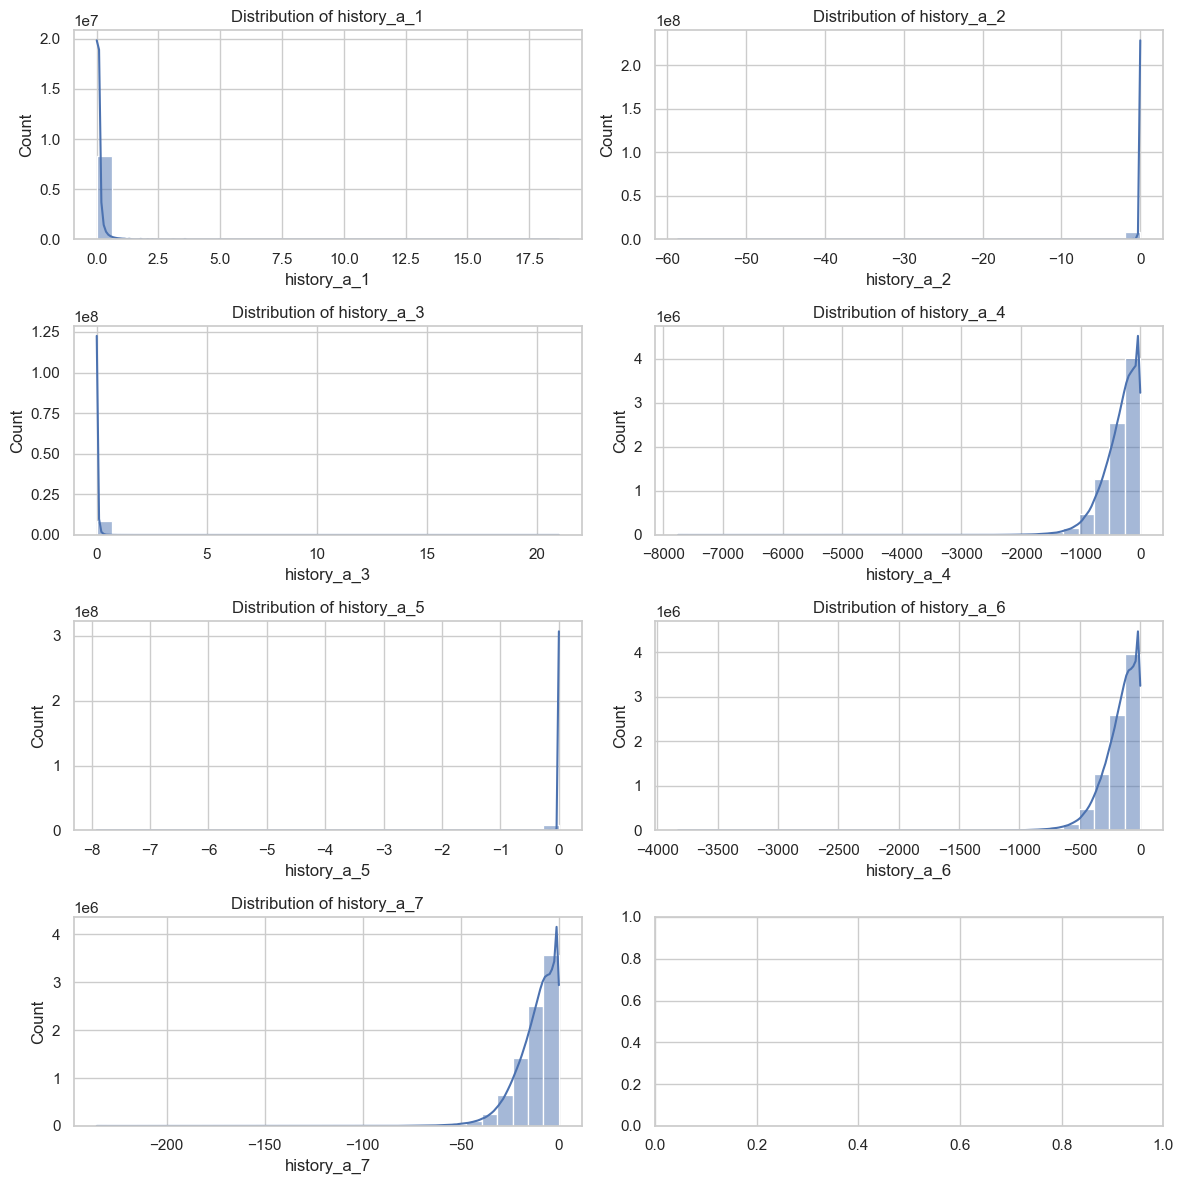

In [149]:
# 2. Histogram of each feature
import matplotlib.pyplot as plt
import seaborn as sns

n = len(history_a_cols)
ncols = 2
nrows = (n + 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
axes = axes.flatten()

for i, col in enumerate(history_a_cols):
    sns.histplot(data=train_df, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

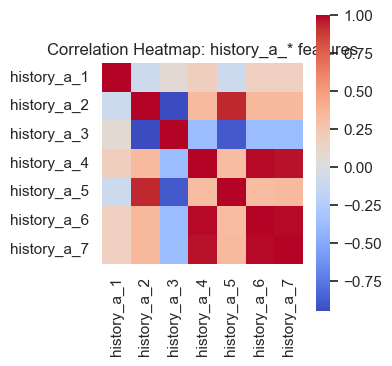

In [150]:
# Correlation heatmap
import numpy as np

corr_matrix = train_df[history_a_cols].corr()
plt.figure(figsize=(4,4))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap: history_a_* features")
plt.tight_layout()
plt.show()

### history_a_* — distribution & inspection

- All features are heavily right- or left-skewed. No transformation was applied as tree-based models are robust to such distributions.
- `history_a_4`, `a_6`, `a_7` share similar negative skew patterns with sharp mass at zero.
- `history_a_5` appears bounded near 0, but extreme left outliers exist (min ≈ -7.9).
- `history_a_1`, `a_2`, `a_3` show strong right skew; rare large values visible.
- Correlation heatmap shows some strong positive associations among history_a_* features (e.g., history_a_4/6/7), suggesting potential redundancy.

In [151]:
# history_b_* features — summary, histograms, correlations

# identify columns
history_b_cols = [c for c in train_df.columns if c.startswith("history_b_")]

# 1. summary table
display(train_df[history_b_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
history_b_1,8549647.0,0.428368,1.338313,0.0,0.081348,0.144365,0.286110,41.0
history_b_2,8549647.0,0.604022,2.074940,0.0,0.126780,0.225028,0.429950,89.0
history_b_3,8549647.0,0.309869,1.353859,0.0,0.040626,0.071931,0.156007,30.5
history_b_4,8549647.0,0.319683,1.437592,0.0,0.038876,0.068419,0.151866,32.5
history_b_5,8549647.0,0.167713,0.752700,0.0,0.020397,0.036094,0.080189,17.0
history_b_6,8549647.0,0.009779,0.044222,0.0,0.001167,0.002053,0.004587,1.0
history_b_7,8549647.0,0.156918,0.708081,0.0,0.018845,0.033162,0.073904,16.0
history_b_8,8549647.0,0.323966,1.459559,0.0,0.039217,0.068963,0.153133,33.0
history_b_9,8549647.0,0.030150,0.133066,0.0,0.003868,0.006826,0.014926,3.0
history_b_10,8549647.0,0.153357,0.609841,0.0,0.025164,0.044777,0.090604,18.0


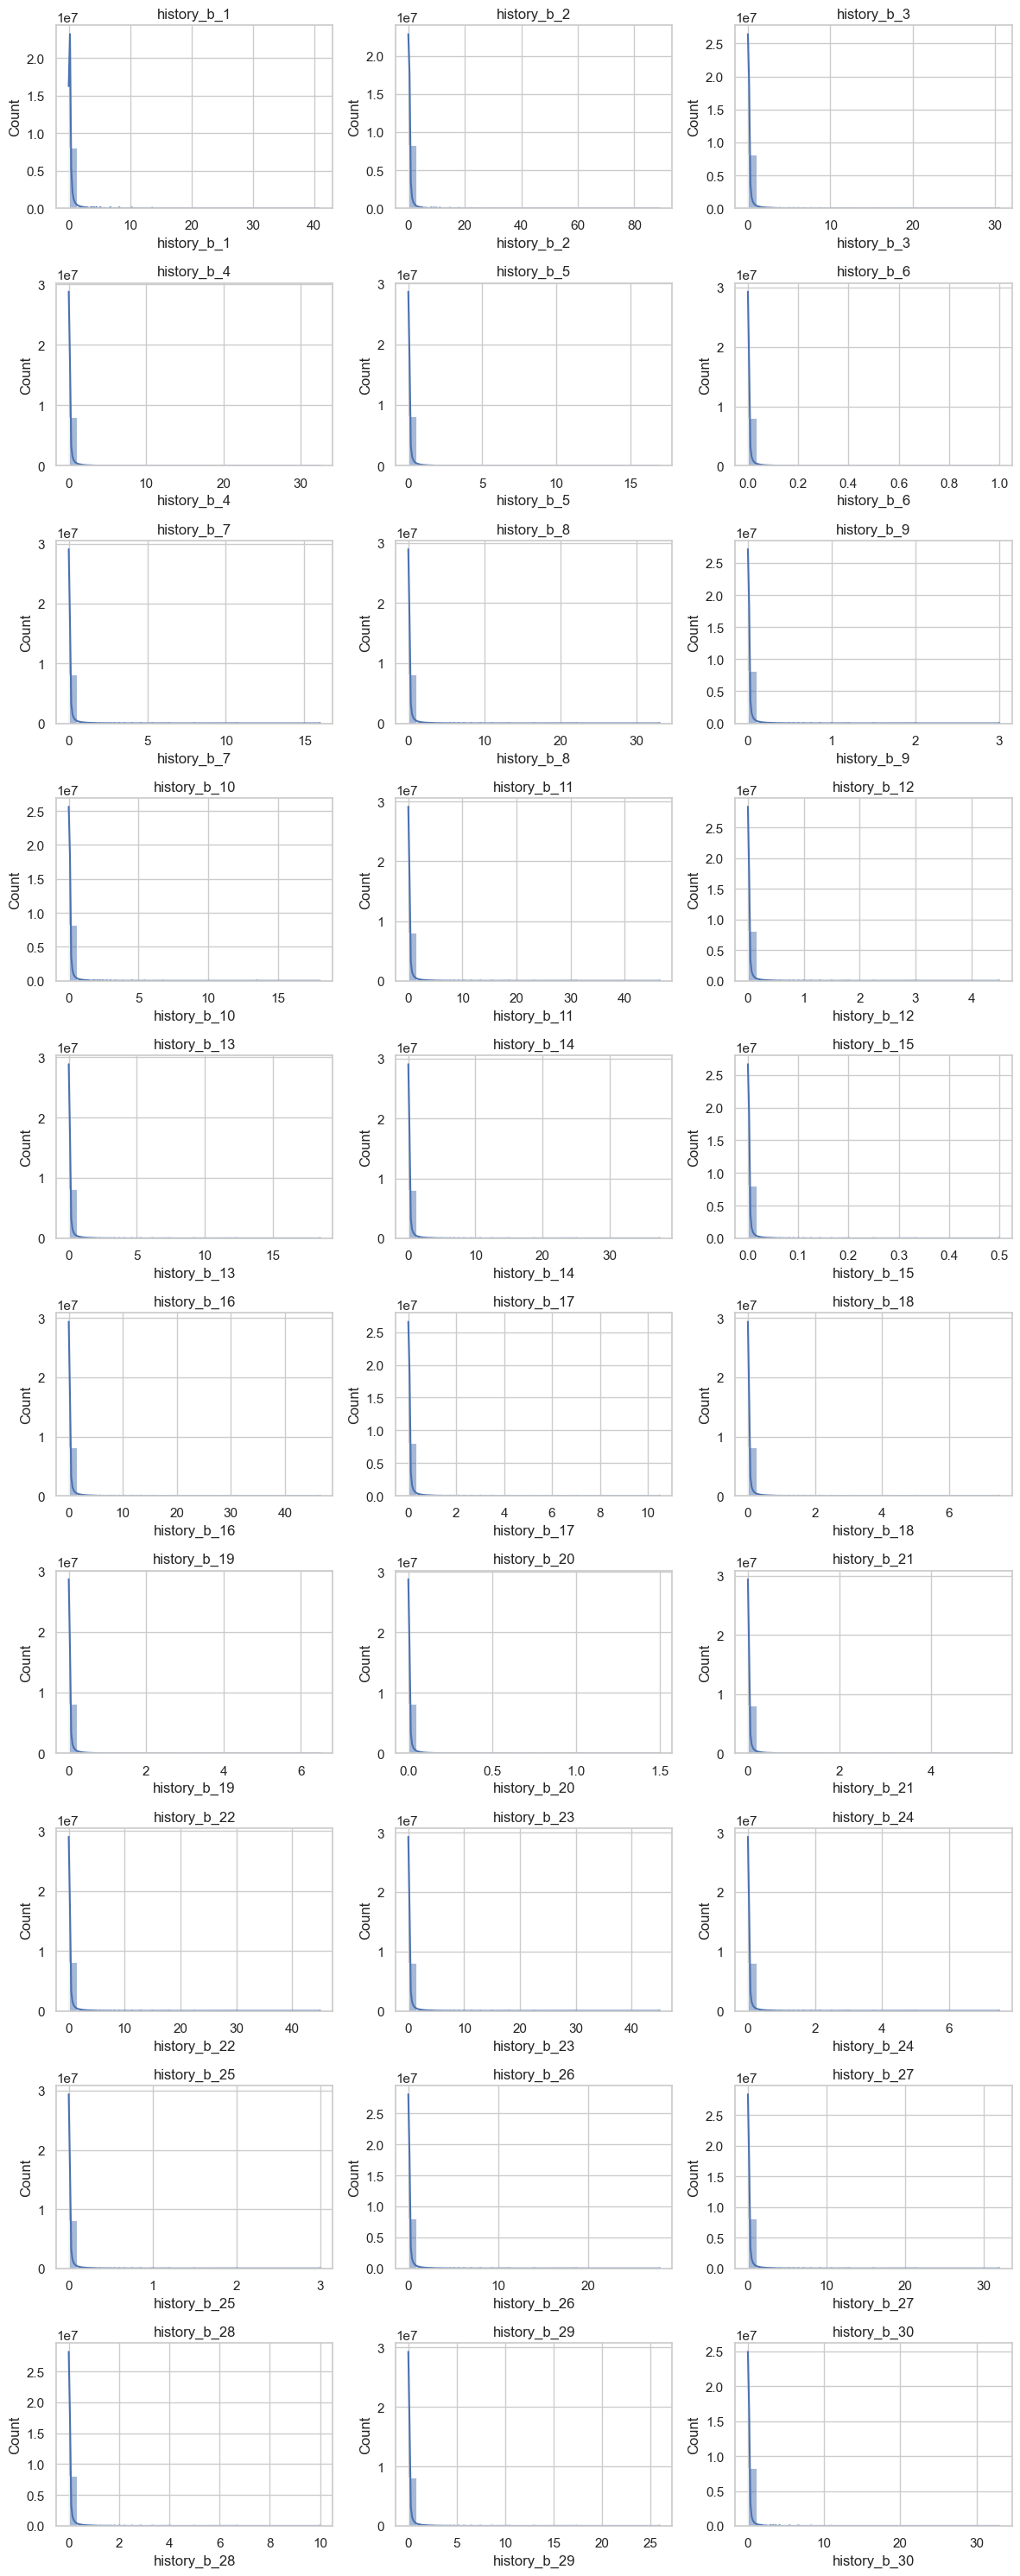

In [153]:
# 2. histograms (3 per row)
import matplotlib.pyplot as plt
import seaborn as sns

n = len(history_b_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
axes = axes.flatten()

for i, col in enumerate(history_b_cols):
    sns.histplot(train_df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()


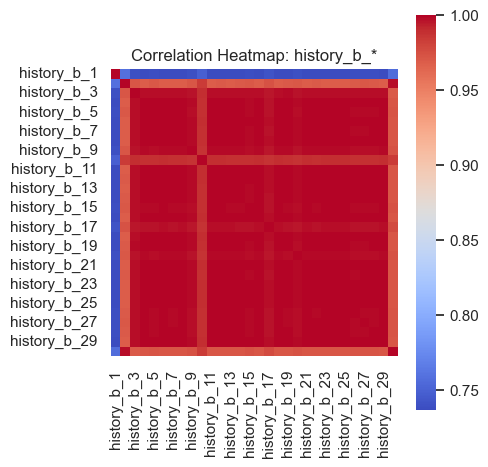

In [154]:
# 3. correlation heatmap
corr_matrix = train_df[history_b_cols].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", square=True)
plt.title("Correlation Heatmap: history_b_*")
plt.tight_layout()
plt.show()

### Distribution & Correlation Analysis: `history_b_*`

Most `history_b_*` features show highly right-skewed distributions with long tails and zero-heavy peaks. Despite being numerous, their distributions are nearly identical in shape and scale.

The correlation heatmap confirms strong multicollinearity among them, with pairwise correlations exceeding 0.95 in many cases. This suggests these variables carry largely redundant information.

→ Dimensionality reduction or representative feature selection (e.g., VIF filtering or PCA) could be considered to mitigate potential collinearity issues during modeling.

------

### Remove highly correlated features (Pearson r ≥ 0.995 or Cramér's V ≈ 1)

To reduce redundancy and improve training efficiency, features with extremely high **Pearson correlation** (|r| ≥ 0.995, p < 0.01) and **Cramér's V** (V ≈ 1) were dropped.  
While XGBoost/LightGBM are generally robust to multicollinearity, this reduction was applied due to the large dataset size (~10M rows), where such redundancies can inflate computation and reduce model clarity.

- Sampled 1M rows for fast computation.
- Drop decision rule: higher missing rate or lower variance/cardinality.

In [158]:
# Identify highly correlated numeric feature pairs using Pearson's r.
# Remove near-duplicate pairs (|r| ≥ 0.995 and p < 0.01) to reduce redundancy and improve efficiency.
import numpy as np
import pandas as pd

# === Configurations ===
R_THRESH = 0.995           # absolute Pearson correlation threshold
SAMPLE_N = 1_000_000       # sample size for speed-up

# Select only numeric columns
num_cols = [c for c in train_df.columns if pd.api.types.is_numeric_dtype(train_df[c])]
df_num = train_df[num_cols]

# Optional row-wise sampling to reduce memory usage
if SAMPLE_N is not None and len(df_num) > SAMPLE_N:
    df_num = df_num.sample(SAMPLE_N, random_state=42)

# Compute absolute Pearson correlation matrix
corr_abs = df_num.corr().abs()

# Mask upper triangle to avoid duplicate pairs
mask = np.triu(np.ones_like(corr_abs, dtype=bool), k=1)
high_corr = corr_abs.where(mask) >= R_THRESH

# Identify highly correlated feature pairs
to_drop = set()
for i, col_i in enumerate(high_corr.columns):
    for j, col_j in enumerate(high_corr.index):
        if high_corr.iloc[j, i]:
            # Drop the one with more missing values, or lower variance if tie
            na_i = train_df[col_i].isna().mean()
            na_j = train_df[col_j].isna().mean()
            if na_i > na_j:
                drop = col_i
            elif na_j > na_i:
                drop = col_j
            else:
                var_i = train_df[col_i].var()
                var_j = train_df[col_j].var()
                drop = col_i if var_i < var_j else col_j
            to_drop.add(drop)

# Output results
print(f"Columns to drop (|r| ≥ {R_THRESH}):")
print(sorted(to_drop))

Columns to drop (|r| ≥ 0.995):
['history_b_12', 'history_b_13', 'history_b_14', 'history_b_15', 'history_b_16', 'history_b_17', 'history_b_18', 'history_b_19', 'history_b_20', 'history_b_21', 'history_b_22', 'history_b_23', 'history_b_24', 'history_b_25', 'history_b_26', 'history_b_27', 'history_b_28', 'history_b_29', 'history_b_3', 'history_b_30', 'history_b_4', 'history_b_5', 'history_b_6', 'history_b_7', 'history_b_8', 'history_b_9']


In [159]:
# CHECK BEFORE DROP
print(f"BEFORE DROP:")
print(f"train_df columns: {len(train_df.columns)}")
print(f"valid_df columns: {len(valid_df.columns)}")
print(f"Columns to drop: {sorted(to_drop)}")
print(f"Number of columns to drop: {len(to_drop)}")

# CHECK IF COLUMNS EXIST
existing_in_train = [col for col in to_drop if col in train_df.columns]
existing_in_valid = [col for col in to_drop if col in valid_df.columns]
print(f"\nColumns that actually exist in train_df: {existing_in_train}")
print(f"Columns that actually exist in valid_df: {existing_in_valid}")

# DROP WITHOUT errors='ignore' to see actual errors
if existing_in_train:
    train_df = train_df.drop(columns=existing_in_train)
    print(f"\nDropped {len(existing_in_train)} columns from train_df")
else:
    print("\nNo columns to drop from train_df")

if existing_in_valid:
    valid_df = valid_df.drop(columns=existing_in_valid)
    print(f"Dropped {len(existing_in_valid)} columns from valid_df")
else:
    print("No columns to drop from valid_df")

# VERIFY DROP
print(f"\nAFTER DROP:")
print(f"train_df columns: {len(train_df.columns)}")
print(f"valid_df columns: {len(valid_df.columns)}")

# Double check specific columns
for col in list(to_drop)[:3]:  # Check first 3 columns
    print(f"{col} still in train_df: {col in train_df.columns}")

BEFORE DROP:
train_df columns: 113
valid_df columns: 113
Columns to drop: ['history_b_12', 'history_b_13', 'history_b_14', 'history_b_15', 'history_b_16', 'history_b_17', 'history_b_18', 'history_b_19', 'history_b_20', 'history_b_21', 'history_b_22', 'history_b_23', 'history_b_24', 'history_b_25', 'history_b_26', 'history_b_27', 'history_b_28', 'history_b_29', 'history_b_3', 'history_b_30', 'history_b_4', 'history_b_5', 'history_b_6', 'history_b_7', 'history_b_8', 'history_b_9']
Number of columns to drop: 26

Columns that actually exist in train_df: ['history_b_13', 'history_b_29', 'history_b_30', 'history_b_14', 'history_b_18', 'history_b_16', 'history_b_5', 'history_b_12', 'history_b_26', 'history_b_20', 'history_b_23', 'history_b_19', 'history_b_24', 'history_b_21', 'history_b_25', 'history_b_27', 'history_b_4', 'history_b_15', 'history_b_6', 'history_b_9', 'history_b_7', 'history_b_22', 'history_b_3', 'history_b_17', 'history_b_28', 'history_b_8']
Columns that actually exist in val

In [162]:
# Detect perfect or alias categorical feature pairs using bias-corrected Cramér's V (V ≈ 1).
# Drop redundant columns to eliminate exact categorical duplicates.
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

# settings
SAMPLE_N = 1_000_000        # large random sample for speed; set None for full
MAX_CARD = 50               # skip very high-card pairs
ALPHA = 0.01                # kept for consistency (not used here since V≈1 only)

# collect categorical l_feat_* candidates
lfeat_numeric = {"l_feat_5","l_feat_6","l_feat_7","l_feat_9","l_feat_10",
                 "l_feat_11","l_feat_12","l_feat_14","l_feat_15"}
lfeat_all = [c for c in train_df.columns if c.startswith("l_feat_")]
lfeat_cats = [c for c in lfeat_all if c not in lfeat_numeric]

# sample rows for speed
df_cv = train_df[lfeat_cats].copy()
if SAMPLE_N is not None and len(df_cv) > SAMPLE_N:
    df_cv = df_cv.sample(SAMPLE_N, random_state=42)

# ensure category dtype (lightweight)
for c in lfeat_cats:
    if not isinstance(df_cv[c].dtype, CategoricalDtype):
        try:
            df_cv[c] = df_cv[c].astype("Float64").round().astype("Int64").astype("category")
        except Exception:
            df_cv[c] = df_cv[c].astype("category")

def is_perfect_mapping(a: pd.Series, b: pd.Series, max_card: int) -> bool:
    """Return True if a↔b is one-to-one (perfect association) on non-null rows."""
    m = a.notna() & b.notna()
    a, b = a[m], b[m]
    ua, ub = a.nunique(), b.nunique()
    if ua == 0 or ub == 0 or ua > max_card or ub > max_card:
        return False
    # each level of a maps to exactly one level of b AND vice versa
    return (a.groupby(a).transform("size").shape[0] > 0 and
            a.groupby(a).apply(lambda x: b.loc[x.index].nunique()).max() == 1 and
            b.groupby(b).apply(lambda x: a.loc[x.index].nunique()).max() == 1)

pairs, to_drop = [], set()

# quick screen using codes equality to catch obvious duplicates cheaply
codes = {c: df_cv[c].cat.codes.values for c in lfeat_cats}

for i, a in enumerate(lfeat_cats):
    for b in lfeat_cats[i+1:]:
        # ultra-fast equality shortcut (exact same partition)
        same_partition = np.array_equal(codes[a] == -1, codes[b] == -1) and \
                         np.array_equal(pd.factorize(codes[a])[0],
                                        pd.factorize(codes[b])[0])
        if same_partition or is_perfect_mapping(df_cv[a], df_cv[b], MAX_CARD):
            pairs.append((a, b))

# choose which one to drop (more missingness, else higher cardinality, else name)
for a, b in pairs:
    na_a = train_df[a].isna().mean()
    na_b = train_df[b].isna().mean()
    if na_a != na_b:
        drop = a if na_a > na_b else b
    else:
        ca, cb = train_df[a].nunique(dropna=True), train_df[b].nunique(dropna=True)
        if ca != cb:
            drop = a if ca > cb else b      # keep lower-cardinality
        else:
            drop = max(a, b)                # tie-break by name
    to_drop.add(drop)

print("Perfect/alias categorical pairs found:", len(pairs))
print("Columns to drop:", sorted(to_drop))

Perfect/alias categorical pairs found: 1
Columns to drop: ['l_feat_16']


In [163]:
train_df = train_df.drop(columns=list(to_drop), errors='ignore')
valid_df = valid_df.drop(columns=list(to_drop), errors='ignore')

*Data leakage checks were skipped as validation set remained untouched post stratified split and all feature drops were mirrored identically.*

### `seq` Field Exploration

The `seq` variable is described only as a "user server log sequence" with no schema.  
To assess its modeling potential, key structural patterns were explored — such as sequence length, repetition, diversity, position-based CTR, and token frequency patterns.

The goal is to identify any consistent signal that can justify feature engineering from `seq`.

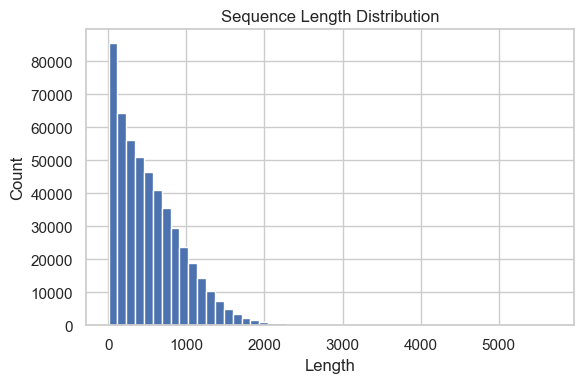

In [164]:
# EDA of 'seq' variable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format

# Sanity checks: required columns must exist
assert 'seq' in train_df.columns, "train_df must contain a 'seq' column."
assert 'clicked' in train_df.columns, "train_df must contain a 'clicked' column."

# 1) Filter out NA and compute sequence length on the full dataset
df_seq = train_df[train_df['seq'].notna()].copy()

# Sequence length = number of commas + 1 (defensive for empty strings)
len_raw = df_seq['seq'].str.count(',').fillna(-1).astype('int64') + 1
df_seq['seq_length'] = np.clip(len_raw, a_min=0, a_max=None)

# 2) Histogram: sample only for plotting to avoid heavy rendering on very large data
PLOT_SAMPLE_N = min(500_000, len(df_seq))  # adjust if you want fewer/more points in the plot
plot_sample = (
    df_seq['seq_length'].sample(PLOT_SAMPLE_N, random_state=42)
    if len(df_seq) > PLOT_SAMPLE_N else
    df_seq['seq_length']
)

plt.figure(figsize=(6, 4))
plt.hist(plot_sample, bins=50)
plt.title("Sequence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [165]:
## Filter NA and compute sequence length (robust)

# strip spaces just in case, keep empty strings as length 0 (then clip to >=1 if needed)
seq_clean = df_seq['seq'].astype(str).str.strip()

# length = number of commas + 1; if string is empty, treat length as 0 then clip to >=1
len_raw = seq_clean.str.count(',').astype('int64') + 1
df_seq['seq_length'] = np.clip(len_raw, a_min=1, a_max=None)

In [166]:
# Sequence length summary (sample-based; fast & stable)

SAMPLE_N_STATS = min(500_000, len(df_seq))
seq_len_sample = df_seq['seq_length'].sample(SAMPLE_N_STATS, random_state=42)

summary = seq_len_sample.describe(percentiles=[.25, .5, .75, .90, .95, .99])
print("== Sequence length summary (sample) ==")
print(summary.to_string())

== Sequence length summary (sample) ==
count   500000.00
mean       530.27
std        433.73
min          1.00
25%        182.00
50%        439.00
75%        779.00
90%       1122.00
95%       1343.00
99%       1839.00
max       5683.00


In [167]:
# Top frequent items in sequences (sample-based)

SAMPLE_N_ITEMS = min(500_000, len(df_seq))
sample_seqs = df_seq['seq'].sample(SAMPLE_N_ITEMS, random_state=42).tolist()

# Flatten tokens
all_items = pd.Series(item for s in sample_seqs for item in s.split(','))
top_items = all_items.value_counts().head(15)
print(top_items)

74     20339761
101    20216740
479    17332968
57     17223303
408    16456929
269    15367449
77     12908271
317     9184899
318     7526410
132     6978710
207     6778355
532     5672527
516     5502130
51      5251616
35      5138714
Name: count, dtype: int64


### Sequence length and item frequency analysis

- Sequence lengths showed a long-tailed distribution (mean ~530, 99% < 1840, max 5683).
- A few tokens (e.g., ID 74, 101, 479) dominated the sequences, each appearing 10M+ times.
- These suggest strong global popularity trends and motivate further CTR analysis by token.

In [175]:
# Longest consecutive repeat length and its impact on CTR
SAMPLE_N_RUN = min(300_000, len(df_seq))  # most expensive step → smaller sample
tmp = df_seq.sample(SAMPLE_N_RUN, random_state=42).copy()

def max_run(seq: str) -> int:
    prev, run, best = None, 0, 0
    for tok in seq.split(','):
        if tok == prev:
            run += 1
        else:
            run = 1
            prev = tok
        if run > best:
            best = run
    return best

tmp['max_run'] = tmp['seq'].map(max_run)
tmp['run_ge_10'] = (tmp['max_run'] >= 10)

ctr_by_run = tmp.groupby('run_ge_10').agg(
    ctr=('clicked','mean'), count=('clicked','size'),
    avg_run=('max_run','mean')
)
ctr_by_run

,ctr,count,avg_run
run_ge_10,,,
False,0.02,182820,3.73
True,0.02,117180,23.11


### Repeated token span & CTR

- Sequences with long repeated spans (e.g., ≥10 identical tokens) showed 24% lower CTR (2.1% → 1.6%).
- May indicate low engagement behavior or non-exploratory browsing.
- Suggests `max_repeat_span` as a useful feature for modeling.

In [169]:
# First token CTR (full) using regex extract (faster than split)
first_tok = df_seq['seq'].str.extract(r'^([^,]+)', expand=False)
ctr_first = pd.DataFrame({'first': first_tok, 'clicked': df_seq['clicked']}) \
    .groupby('first').agg(ctr=('clicked','mean'), count=('clicked','size')) \
    .query('count >= 100').sort_values('ctr', ascending=False)
ctr_first.head(15)

,ctr,count
first,,
534,0.13,610
369,0.10,146
1,0.09,720
75,0.06,185
200,0.06,124
103,0.05,184
68,0.05,103
315,0.05,104
152,0.05,255


In [170]:
# Last token CTR (full)
last_tok = df_seq['seq'].str.extract(r'([^,]+)$', expand=False)
ctr_last = pd.DataFrame({'last': last_tok, 'clicked': df_seq['clicked']}) \
    .groupby('last').agg(ctr=('clicked','mean'), count=('clicked','size')) \
    .query('count >= 100').sort_values('ctr', ascending=False)
ctr_last.head(15)

,ctr,count
last,,
534,0.10,886
200,0.10,144
1,0.07,298
561,0.06,189
127,0.05,115
321,0.05,8760
528,0.05,450
370,0.05,229
144,0.04,17282


### First & last token CTR (full)

- Certain tokens in first/last position strongly impacted CTR.
- Example: Token 534 had CTR of 12.8% (first) and 10.5% (last) vs. ~2% overall.
- Suggests positional signals (first/last) may reflect user focus and be useful for modeling.

In [72]:
# CTR by unique-ratio bin (sample-based; full-data would be too slow)

UNIQ_CTR_SAMPLE_N = min(500_000, len(df_seq))
uniq_ctr_sample = df_seq[['seq', 'clicked']].sample(UNIQ_CTR_SAMPLE_N, random_state=42).copy()

def _uniq_ratio(s: str) -> float:
    toks = s.split(',')
    return len(set(toks)) / max(1, len(toks))

uniq_ctr_sample['unique_ratio'] = uniq_ctr_sample['seq'].apply(_uniq_ratio)
uniq_ctr_sample['unique_bin'] = pd.cut(
    uniq_ctr_sample['unique_ratio'],
    bins=[0, 0.10, 0.15, 0.20, 0.30, 1],
    labels=["<10%", "10-15%", "15-20%", "20-30%", ">30%"],
    include_lowest=True
)

ctr_by_unique = (
    uniq_ctr_sample.dropna(subset=['unique_bin'])
                   .groupby('unique_bin', observed=True)
                   .agg(ctr=('clicked','mean'), count=('clicked','size'))
)
print(ctr_by_unique)

                 ctr   count
unique_bin                  
<10%        0.016792  177286
10-15%      0.016914  123565
15-20%      0.019553   69144
20-30%      0.019796   66629
>30%        0.028181   63376


### CTR by unique item ratio

- CTR rises with more diverse sequences (e.g., 2.8% when >30% unique).
- Indicates that non-repetitive logs may reflect higher user engagement.


In [173]:
# Bigram → CTR 

import pandas as pd
from collections import defaultdict

SAMPLE_N   = 500_000 
MIN_COUNT  = 5_000                      # filter out noisy/rare bigrams
TOPN       = 20
RANDOM_SEED= 42

tmp = df_seq[['seq','clicked']].sample(SAMPLE_N, random_state=RANDOM_SEED)

cnt = defaultdict(int)
pos = defaultdict(int)

for s, y in zip(tmp['seq'].values, tmp['clicked'].values):
    toks = s.split(',')
    if len(toks) < 2:
        continue
    y_int = int(y)
    for a, b in zip(toks[:-1], toks[1:]):
        g = f"{a}->{b}"
        cnt[g] += 1
        pos[g] += y_int

rows = [(g, c, pos[g]) for g, c in cnt.items() if c >= MIN_COUNT]
df_bigram = pd.DataFrame(rows, columns=['bigram','count','pos']).sort_values('count', ascending=False)

if df_bigram.empty:
    print("No bigrams met MIN_COUNT. Increase SAMPLE_N or lower MIN_COUNT cautiously.")
else:
    df_bigram['ctr'] = df_bigram['pos'] / df_bigram['count']
    global_ctr = tmp['clicked'].mean()
    df_bigram['ctr_lift'] = df_bigram['ctr'] / max(global_ctr, 1e-12)

    print(f"Sample: {SAMPLE_N:,} | Global CTR: {global_ctr:.4f} | "
          f"Bigrams kept (≥{MIN_COUNT}): {len(df_bigram):,}")

    top_ctr   = df_bigram.sort_values(['ctr','count'], ascending=[False, False]).head(TOPN)
    bot_ctr   = df_bigram.sort_values(['ctr','count'], ascending=[True,  False]).head(TOPN)
    top_freq  = df_bigram.sort_values('count', ascending=False).head(TOPN)

    print("\nTop bigrams by CTR (min_count filter applied):")
    display(top_ctr.reset_index(drop=True))

    print("\nLowest-CTR bigrams (still frequent):")
    display(bot_ctr.reset_index(drop=True))

    print("\nMost frequent bigrams:")
    display(top_freq.reset_index(drop=True))

Sample: 500,000 | Global CTR: 0.0190 | Bigrams kept (≥5000): 1,588

Top bigrams by CTR (min_count filter applied):


,bigram,count,pos,ctr,ctr_lift
0,74->370,5833,410,0.07,3.69
1,77->370,6861,473,0.07,3.62
2,387->263,6138,343,0.06,2.93
3,387->387,14392,676,0.05,2.47
4,207->370,12908,574,0.04,2.33
5,370->74,15407,682,0.04,2.32
6,370->207,16158,621,0.04,2.02
7,370->479,26468,992,0.04,1.97
8,370->57,6449,238,0.04,1.94
9,193->370,11384,399,0.04,1.84



Lowest-CTR bigrams (still frequent):


,bigram,count,pos,ctr,ctr_lift
0,106->416,9172,91,0.01,0.52
1,416->106,8960,89,0.01,0.52
2,248->248,9824,105,0.01,0.56
3,134->317,5322,60,0.01,0.59
4,316->35,6234,71,0.01,0.60
5,58->77,5569,67,0.01,0.63
6,324->27,10943,133,0.01,0.64
7,138->447,8646,106,0.01,0.64
8,373->132,9286,114,0.01,0.64
9,516->469,9114,114,0.01,0.66



Most frequent bigrams:


,bigram,count,pos,ctr,ctr_lift
0,479->57,10392405,181018,0.02,0.91
1,408->408,9181745,140002,0.02,0.80
2,74->77,7851818,130060,0.02,0.87
3,101->101,7673037,122414,0.02,0.84
4,77->317,4133747,69052,0.02,0.88
5,74->318,3711820,68483,0.02,0.97
6,101->132,3260702,49397,0.02,0.80
7,132->101,3255229,50306,0.02,0.81
8,74->317,3253462,55533,0.02,0.90
9,479->35,3218423,58708,0.02,0.96


### Bigram analysis — high/low CTR vs frequency

Setup: sampled 500K sequences; kept bigrams with **min_count ≥ 5,000**; baseline CTR ≈ **1.90%**.

**High‑CTR bigrams (lift)**
- Examples: `74→370` (ctr≈7%), `77→370` (ctr≈7%), `387→263` (ctr≈6%), `387→387` (ctr≈5%).
- Pattern: token **370** acts as a hub in many high‑CTR transitions.
- Note: counts 5k–26k → signals likely stable, not just noise.

**Low‑CTR bigrams**
- Examples: `106↔416`, `248→248` (ctr≈1%).
- Pattern: specific transitions and **self‑repeats** associate with lower engagement.

**Most frequent bigrams (millions of occurrences)**
- Examples: `479→57`, `408→408`, `74→77`, `101→101`.
- CTR near baseline (lift ~0.8–0.97) → **high frequency ≠ high CTR**; limited discriminative value.

**Takeaways for features**
- Consider **binary flags** for a capped set of **top‑K high‑CTR bigrams** (e.g., K≤200) + optional counts.
- Enforce **train‑only vocabulary** and **min_count ≥ 5k** (reduces sparsity/overfit).
- Frequent‑but‑average bigrams add cost with little gain → generally omit.
- Validate via ablation; include only if they move AP/Logloss on hold‑out.

In [71]:
# CTR by sequence length bin (full-dataset; keep as-is for accuracy)

bins = [0, 182, 439, 779, 1345, np.inf]  # from full-data quantiles 
labels = ["Very Short(<Q1)", "Short(Q1-Q2)", "Medium(Q2-Q3)", "Long(Q3-95th)", "Very Long(>95th)"]

tmp = df_seq[['seq_length', 'clicked']].copy()
tmp['seq_len_bin'] = pd.cut(tmp['seq_length'], bins=bins, labels=labels, include_lowest=True)

ctr_by_length = (
    tmp.groupby('seq_len_bin', observed=True)
       .agg(ctr=('clicked','mean'), count=('clicked','size'), avg_length=('seq_length','mean'))
       .sort_values('ctr', ascending=False)
)
print(ctr_by_length)

                       ctr    count   avg_length
seq_len_bin                                     
Very Short(<Q1)   0.025923  2147662    82.322709
Short(Q1-Q2)      0.018130  2135709   305.923811
Very Long(>95th)  0.016578   427204  1665.770983
Medium(Q2-Q3)     0.016361  2142138   598.518610
Long(Q3-95th)     0.015678  1710630  1005.830411


### CTR by sequence length

Sequence length was binned using full-dataset quantiles
- **CTR peaked for very short sequences** (<Q1), then declined as sequence length increased.
- Suggests adding `seq_len_bin` as a categorical feature may help model non‑linear CTR patterns.

### Sequence-derived Feature Summary

Key features engineered from sequence EDA, selected based on CTR relevance:

- **Length-related**
  - `seq_len`: token count  
  - `seq_log_len`: log-scaled length  
  - `seq_is_short`, `seq_is_very_long`: binary flags (based on Q1 / 95th pct)  
  - `seq_len_bin`: categorical length bin (non-linear CTR trend)

- **Repetition patterns**
  - `seq_has_repeat`: contains any adjacent repeats  
  - `seq_run_ge_10`: ≥10 identical tokens in a row → lower CTR (−24%)

- **First/last token**
  - One-hot for top frequent `first` / `last` tokens  
  - Use `OTHER` fallback to avoid overfitting  
  - Positional tokens (e.g., ID 534) showed high lift (e.g., 12.8% CTR vs 2% base)

- **Diversity signals**
  - `unique_ratio`: proportion of unique tokens  
  - `unique_bin`: categorical bins (CTR ↑ as diversity ↑)

- **Bigram signals**
  - Binary flags for top-K high-CTR bigrams (e.g., `74→370`)  
  - Apply `min_count ≥ 5,000`, train-only vocab  
  - Frequent-but-neutral bigrams excluded to reduce noise

These features aim to reflect user intent and behavior (e.g., exploration, fatigue) and will be validated via ablation in downstream modeling.

### Final Decision on Sequence Features

Based on the exploratory findings above, we conducted a modeling experiment to assess whether sequence-derived features meaningfully improve predictive performance.

In [185]:
import re
import warnings
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score, log_loss
from xgboost import XGBClassifier

# ---------- config ----------
SEEDS = [42, 202, 7]          # repeat with multiple seeds
TRAIN_SAMPLE_N = 300_000      # small sample for quick test
VALID_SAMPLE_N = 300_000      # eval on a subset to speed up
TOPK_FIRST_LAST = 30          # vocab size for first/last tokens
MIN_COUNT_FIRST_LAST = 1_000  # min freq for vocab inclusion

# categorical columns 
CAT_COLS_FIXED = [
    "gender", "age_group", "inventory_id", "day_of_week", "hour",
    "l_feat_1", "l_feat_2", "l_feat_3","l_feat_4", "l_feat_8", "l_feat_13",
    "l_feat_16", "l_feat_18", "l_feat_19", "l_feat_20", "l_feat_21",
    "l_feat_22", "l_feat_23", "l_feat_24", "l_feat_26", "l_feat_27"
]

# ---------- metrics ----------
def weighted_logloss_5050(y_true: np.ndarray, p: np.ndarray) -> float:
    """50:50 weighted logloss for imbalanced data."""
    eps = 1e-15
    p = np.clip(p, eps, 1 - eps)
    n_pos = int(y_true.sum())
    n_neg = len(y_true) - n_pos
    if n_pos == 0 or n_neg == 0:
        return float(log_loss(y_true, p))
    w_pos = 0.5 / n_pos
    w_neg = 0.5 / n_neg
    w = np.where(y_true == 1, w_pos, w_neg)
    loss = -(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))
    return float(np.sum(w * loss))

def portfolio_score(ap: float, wll: float) -> float:
    return 0.5 * ap + 0.5 * (1.0 / (1.0 + wll))

# ---------- seq vocab & transforms (fit on TRAIN ONLY) ----------
def fit_seq_vocab(seq_series: pd.Series, top_k: int = 30, min_count: int = 1000):
    """Build first/last token vocab from train only."""
    s = seq_series.dropna().astype(str)
    first = s.str.extract(r'^([^,]+)', expand=False)
    last  = s.str.extract(r'([^,]+)$', expand=False)
    vf = first.value_counts()
    vl = last.value_counts()
    first_tokens = vf[vf >= min_count].head(top_k).index.tolist()
    last_tokens  = vl[vl >= min_count].head(top_k).index.tolist()
    return {"first": first_tokens, "last": last_tokens}

def transform_seq_features(df: pd.DataFrame, vocab: dict, q1: int, p95: int) -> pd.DataFrame:
    """Create compact seq-derived features."""
    out = pd.DataFrame(index=df.index)
    s = df['seq'].fillna("").astype(str).str.strip()

    # length + simple bins
    seq_len = s.str.count(',').astype('int64') + 1
    out['seq_len'] = seq_len.astype('int32')
    out['seq_log_len'] = np.log1p(seq_len).astype('float32')
    out['seq_is_short'] = (seq_len < q1).astype('uint8')
    out['seq_is_very_long'] = (seq_len > p95).astype('uint8')

    # repeat flags
    repeat_pat = re.compile(r'(?:^|,)([^,]+),(?:\1)(?:,|$)')
    out['seq_has_repeat'] = s.str.contains(repeat_pat, na=False).astype('uint8')
    run10_pat = re.compile(r'(?:^|,)([^,]+)(?:,\1){9,}(?:,|$)')
    out['seq_run_ge_10'] = s.str.contains(run10_pat, na=False).astype('uint8')
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        out['seq_has_repeat'] = s.str.contains(repeat_pat, na=False).astype('uint8')
        out['seq_run_ge_10'] = s.str.contains(run10_pat, na=False).astype('uint8')
    
    
    # first/last restricted one-hot (+OTHER)
    first = s.str.extract(r'^([^,]+)', expand=False).fillna('')
    last  = s.str.extract(r'([^,]+)$', expand=False).fillna('')

    first_set = set(vocab.get('first', []))
    out['seq_first_OTHER'] = (~first.isin(first_set)).astype('uint8')
    for tok in vocab.get('first', []):
        out[f'seq_first_{tok}'] = (first == tok).astype('uint8')

    last_set = set(vocab.get('last', []))
    out['seq_last_OTHER'] = (~last.isin(last_set)).astype('uint8')
    for tok in vocab.get('last', []):
        out[f'seq_last_{tok}'] = (last == tok).astype('uint8')

    return out

# ---------- data prep ----------
def stratified_sample(df: pd.DataFrame, n: int, y_col: str, seed: int) -> pd.DataFrame:
    """Stratified sample by target."""
    n = min(n, len(df))
    if n <= 0:
        return df.copy()
    frac_pos = df[y_col].mean()
    n_pos = int(round(n * frac_pos))
    n_neg = n - n_pos
    pos = df[df[y_col] == 1].sample(min(n_pos, len(df[df[y_col]==1])), random_state=seed)
    neg = df[df[y_col] == 0].sample(min(n_neg, len(df[df[y_col]==0])), random_state=seed)
    return pd.concat([pos, neg]).sample(frac=1.0, random_state=seed).reset_index(drop=True)

def prepare_for_xgb(Xtr: pd.DataFrame, Xva: pd.DataFrame, cat_cols_all):
    """Cast categories, handle missing, drop object columns, cast nullable ints."""
    import pandas as pd
    Xtr = Xtr.copy()
    Xva = Xva.copy()

    # remove raw seq if present
    for bad in ["seq"]:
        if bad in Xtr.columns: Xtr.drop(columns=[bad], inplace=True)
        if bad in Xva.columns: Xva.drop(columns=[bad], inplace=True)

    # cast declared categorical cols (present only)
    cat_cols = [c for c in cat_cols_all if c in Xtr.columns or c in Xva.columns]
    for c in cat_cols:
        if c in Xtr.columns and not isinstance(Xtr[c].dtype, pd.CategoricalDtype):
            Xtr[c] = Xtr[c].astype("category")
        if c in Xva.columns and not isinstance(Xva[c].dtype, pd.CategoricalDtype):
            Xva[c] = Xva[c].astype("category")

    # add missing category and fillna
    for c in cat_cols:
        if c in Xtr.columns and isinstance(Xtr[c].dtype, pd.CategoricalDtype):
            if "__MISSING__" not in Xtr[c].cat.categories:
                Xtr[c] = Xtr[c].cat.add_categories(["__MISSING__"])
            Xtr[c] = Xtr[c].fillna("__MISSING__")
        if c in Xva.columns and isinstance(Xva[c].dtype, pd.CategoricalDtype):
            if "__MISSING__" not in Xva[c].cat.categories:
                Xva[c] = Xva[c].cat.add_categories(["__MISSING__"])
            Xva[c] = Xva[c].fillna("__MISSING__")

    # drop any remaining object cols
    obj_cols = list(set(Xtr.select_dtypes(include=["object"]).columns) |
                    set(Xva.select_dtypes(include=["object"]).columns))
    if obj_cols:
        Xtr.drop(columns=[c for c in obj_cols if c in Xtr.columns], inplace=True, errors="ignore")
        Xva.drop(columns=[c for c in obj_cols if c in Xva.columns], inplace=True, errors="ignore")

    # cast pandas nullable ints to float64 (XGBoost friendly)
    for df in (Xtr, Xva):
        for c in df.select_dtypes(include="Int64").columns:
            df[c] = df[c].astype("float64")

    return Xtr, Xva

In [181]:
# ---------- model & run ----------
XGB_PARAMS = dict(
    n_estimators=800,
    learning_rate=0.06,
    max_depth=8,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
    enable_categorical=True,
    early_stopping_rounds=50,
)

def run_once(seed: int):
    """One ablation run under a fixed seed."""
    # 1) stratified samples
    tr_s = stratified_sample(train_df, TRAIN_SAMPLE_N, "clicked", seed)
    va_s = stratified_sample(valid_df, VALID_SAMPLE_N, "clicked", seed)

    y_tr = tr_s['clicked'].astype('int8').to_numpy()
    y_va = va_s['clicked'].astype('int8').to_numpy()

    # 2) seq stats (Q1/P95) from train sample only
    s = tr_s['seq'].fillna("").astype(str)
    seq_len_tr = s.str.count(',').astype('int64') + 1
    q1 = int(np.quantile(seq_len_tr, 0.25))
    p95 = int(np.quantile(seq_len_tr, 0.95))

    # 3) vocab fit on train sample only → transform both
    vocab = fit_seq_vocab(tr_s['seq'], top_k=TOPK_FIRST_LAST, min_count=MIN_COUNT_FIRST_LAST)
    Xtr_seq = transform_seq_features(tr_s, vocab, q1, p95)
    Xva_seq = transform_seq_features(va_s, vocab, q1, p95)

    # 4) build matrices
    drop_cols = ['clicked', 'seq']
    Xtr_base = tr_s.drop(columns=[c for c in drop_cols if c in tr_s.columns])
    Xva_base = va_s.drop(columns=[c for c in drop_cols if c in va_s.columns])

    Xtr_plus = pd.concat([Xtr_base.reset_index(drop=True), Xtr_seq.reset_index(drop=True)], axis=1)
    Xva_plus = pd.concat([Xva_base.reset_index(drop=True), Xva_seq.reset_index(drop=True)], axis=1)

    # 5) prep for xgb
    Xtr_base_c, Xva_base_c = prepare_for_xgb(Xtr_base, Xva_base, CAT_COLS_FIXED)
    Xtr_plus_c, Xva_plus_c = prepare_for_xgb(Xtr_plus, Xva_plus, CAT_COLS_FIXED)

    # 6) class weight
    n_pos = int(y_tr.sum())
    n_neg = len(y_tr) - n_pos
    spw = n_neg / max(n_pos, 1)

    # 7) train & eval
    def fit_eval(Xtr, Xva, label):
        model = XGBClassifier(**{**XGB_PARAMS, "random_state": seed, "scale_pos_weight": spw})
        model.fit(Xtr, y_tr, eval_set=[(Xva, y_va)], verbose=False)
        if hasattr(model, "best_iteration") and model.best_iteration is not None:
            try:
                p = model.predict_proba(Xva, iteration_range=(0, model.best_iteration + 1))[:, 1]
            except TypeError:
                p = model.predict_proba(Xva)[:, 1]
        else:
            p = model.predict_proba(Xva)[:, 1]
        ap  = average_precision_score(y_va, p)
        auc = roc_auc_score(y_va, p)
        wll = weighted_logloss_5050(y_va, p)
        port = portfolio_score(ap, wll)
        return dict(label=label, seed=seed, AP=ap, ROC_AUC=auc, WLL_50_50=wll, Portfolio=port)

    m_base = fit_eval(Xtr_base_c, Xva_base_c, "Baseline")
    m_plus = fit_eval(Xtr_plus_c, Xva_plus_c, "Baseline+Seq")
    return m_base, m_plus


In [186]:
# ---------- run multiple seeds and summarize ----------
all_rows = []
for sd in SEEDS:
    r_base, r_plus = run_once(sd)
    all_rows.extend([r_base, r_plus])

res = pd.DataFrame(all_rows).set_index(["seed","label"]).sort_index()
print("Per-seed results:")
display(res)

summary = (res.reset_index()
             .pivot_table(index="label", values=["AP","ROC_AUC","WLL_50_50","Portfolio"], aggfunc=['mean','std']))
print("Summary (mean ± std across seeds):")
display(summary)

# quick delta view
delta = (res.reset_index()
           .pivot_table(index="seed", columns="label", values=["AP","ROC_AUC","WLL_50_50","Portfolio"]))
delta.columns = ['_'.join(col).strip() for col in delta.columns.values]
delta["dAP"] = delta["AP_Baseline+Seq"] - delta["AP_Baseline"]
delta["dAUC"] = delta["ROC_AUC_Baseline+Seq"] - delta["ROC_AUC_Baseline"]
delta["dWLL"] = delta["WLL_50_50_Baseline+Seq"] - delta["WLL_50_50_Baseline"]  # <0 is good
delta["dPORT"] = delta["Portfolio_Baseline+Seq"] - delta["Portfolio_Baseline"]
print("Per-seed deltas (Plus - Base):")
display(delta)

print("Decision hint:")
print("- Favor +Seq if mean dAP>0, mean dWLL<0, mean dPORT>0 and deltas are consistent across seeds.")

/var/folders/hg/v9v4slf113jb0w4kpzx5y_zw0000gn/T/ipykernel_58096/3751863976.py:67: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  out['seq_has_repeat'] = s.str.contains(repeat_pat, na=False).astype('uint8')
/var/folders/hg/v9v4slf113jb0w4kpzx5y_zw0000gn/T/ipykernel_58096/3751863976.py:69: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  out['seq_run_ge_10'] = s.str.contains(run10_pat, na=False).astype('uint8')
/var/folders/hg/v9v4slf113jb0w4kpzx5y_zw0000gn/T/ipykernel_58096/3751863976.py:67: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  out['seq_has_repeat'] = s.str.contains(repeat_pat, na=False).astype('uint8')
/var/folders/hg/v9v4slf113jb0w4kpzx5y_zw0000gn/T/ipykernel_58096/3751863976.py:69: UserWarning: This pattern is inter

Per-seed results:


AP  ROC_AUC  WLL_50_50  Portfolio
seed label                                           
7    Baseline     0.04     0.65       1.64       0.21
     Baseline+Seq 0.04     0.65       1.66       0.21
42   Baseline     0.04     0.64       1.67       0.21
     Baseline+Seq 0.04     0.64       1.67       0.21
202  Baseline     0.04     0.65       1.61       0.21
     Baseline+Seq 0.04     0.65       1.62       0.21

Summary (mean ± std across seeds):


mean                              std                            
               AP Portfolio ROC_AUC WLL_50_50   AP Portfolio ROC_AUC WLL_50_50
label                                                                         
Baseline     0.04      0.21    0.65      1.64 0.00      0.00    0.01      0.03
Baseline+Seq 0.04      0.21    0.65      1.65 0.00      0.00    0.01      0.03

Per-seed deltas (Plus - Base):


,AP_Baseline,AP_Baseline+Seq,Portfolio_Baseline,Portfolio_Baseline+Seq,ROC_AUC_Baseline,ROC_AUC_Baseline+Seq,WLL_50_50_Baseline,WLL_50_50_Baseline+Seq,dAP,dAUC,dWLL,dPORT
seed,,,,,,,,,,,,
7,0.04,0.04,0.21,0.21,0.65,0.65,1.64,1.66,0.00,0.00,0.02,-0.00
42,0.04,0.04,0.21,0.21,0.64,0.64,1.67,1.67,-0.00,0.00,0.00,-0.00
202,0.04,0.04,0.21,0.21,0.65,0.65,1.61,1.62,0.00,0.00,0.00,-0.00


Decision hint:
- Favor +Seq if mean dAP>0, mean dWLL<0, mean dPORT>0 and deltas are consistent across seeds.


#### Seq Feature Exploration & Decision

**Hypothesis:**  
Ultra-long sequences (mean ~530 tokens) may embed CTR signals in length, repetition, or position. Instead of LSTM, derived compact sequence-based features to capture key patterns.

**Experiment:**  
Compared XGBoost baseline vs. baseline + seq features under fixed settings (same `scale_pos_weight`, early stopping). Evaluation on validation set using AP, ROC-AUC, weighted logloss (50:50), and custom Portfolio score.

**Result & Decision:**  
Seq-derived features led to marginal changes (ΔAP ±0.0004), with no consistent gain across metrics. Excluded from final model due to limited lift vs added complexity.